In [16]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from scipy import stats
from typing import List, Tuple, Dict
import warnings
warnings.filterwarnings('ignore')

# Задача о рюкзаке

In [ ]:
class KnapsackProblem:
    """Задача о рюкзаке - классическая комбинаторная задача"""
    def __init__(self, n_items: int, capacity: float, seed: int = None):
        self.n_items = n_items
        self.capacity = capacity
        self.seed = seed if seed is not None else np.random.randint(1000)

        np.random.seed(self.seed)
        # Генерируем случайные веса и стоимости
        self.weights = np.random.uniform(1, 20, n_items)
        self.values = np.random.uniform(10, 100, n_items)
        # Делаем стоимость коррелированной с весом
        self.values = self.values * (1 + 0.3 * self.weights / np.mean(self.weights))

    def evaluate(self, chromosome: np.ndarray) -> float:
        """Оценка решения для задачи о рюкзаке"""
        total_weight = np.dot(chromosome, self.weights)
        total_value = np.dot(chromosome, self.values)

        # Штраф
        if total_weight > self.capacity:
            penalty = np.exp(2 * (total_weight - self.capacity) / self.capacity) * 100
            return max(0, total_value - penalty)
        return total_value


# Классический генетический алгоритм

In [ ]:
class StandardGeneticAlgorithm:
    """Стандартный генетический алгоритм для сравнения с GEA"""

    def __init__(self,
                 problem: KnapsackProblem,
                 population_size: int = 100,
                 max_generations: int = 200,
                 crossover_rate: float = 0.8,
                 mutation_rate: float = 0.02,
                 elite_count: int = 10):

        self.problem = problem
        self.population_size = population_size
        self.max_generations = max_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elite_count = elite_count
        self.chromosome_length = problem.n_items

        self.population = self._initialize_population()
        self.best_solution = None
        self.best_fitness = 0
        self.fitness_history = []
        self.convergence_generation = 0

    def _initialize_population(self) -> List[np.ndarray]:
        """Инициализация случайной популяции"""
        return [np.random.randint(0, 2, self.chromosome_length)
                for _ in range(self.population_size)]

    def evaluate_population(self) -> List[float]:
        """Оценка пригодности всей популяции"""
        return [self.problem.evaluate(ind) for ind in self.population]

    def select_parents(self, fitness_values: List[float]) -> Tuple[np.ndarray, np.ndarray]:
        """Рулеточная селекция"""
        total_fitness = sum(fitness_values)
        if total_fitness == 0:
            probabilities = [1/len(fitness_values)] * len(fitness_values)
        else:
            probabilities = [f/total_fitness for f in fitness_values]

        idx1 = np.random.choice(len(self.population), p=probabilities)
        idx2 = np.random.choice(len(self.population), p=probabilities)

        return self.population[idx1].copy(), self.population[idx2].copy()

    def crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Одноточечный кроссовер"""
        if random.random() > self.crossover_rate:
            return parent1.copy(), parent2.copy()

        point = random.randint(1, self.chromosome_length - 1)
        child1 = np.concatenate([parent1[:point], parent2[point:]])
        child2 = np.concatenate([parent2[:point], parent1[point:]])

        return child1, child2

    def mutate(self, chromosome: np.ndarray) -> np.ndarray:
        """Мутация особи"""
        mutated = chromosome.copy()
        for i in range(self.chromosome_length):
            if random.random() < self.mutation_rate:
                mutated[i] = 1 - mutated[i]
        return mutated

    def run(self) -> Dict:
        """Запуск стандартного GA"""
        start_time = time.time()
        convergence_threshold = 0.001  # Порог сходимости (0.1%)
        no_improvement_count = 0
        last_best = -np.inf

        for generation in range(self.max_generations):
            # Оценка пригодности
            fitness_values = self.evaluate_population()
            current_best = max(fitness_values)

            # Проверка сходимости
            if generation > 0:
                improvement = (current_best - last_best) / abs(last_best) if last_best != 0 else 1
                if improvement < convergence_threshold:
                    no_improvement_count += 1
                else:
                    no_improvement_count = 0

                if no_improvement_count >= 10:  # Если 10 поколений без улучшений
                    if self.convergence_generation == 0:
                        self.convergence_generation = generation

            last_best = current_best

            # Обновление лучшего решения
            best_idx = np.argmax(fitness_values)
            if fitness_values[best_idx] > self.best_fitness:
                self.best_fitness = fitness_values[best_idx]
                self.best_solution = self.population[best_idx].copy()

            # Сохранение истории
            self.fitness_history.append({
                'best': current_best,
                'average': np.mean(fitness_values),
                'worst': min(fitness_values),
                'std': np.std(fitness_values)
            })

            # Создание нового поколения
            new_population = []

            # Элитизм
            sorted_indices = np.argsort(fitness_values)[::-1]
            for i in range(min(self.elite_count, self.population_size)):
                new_population.append(self.population[sorted_indices[i]].copy())

            # Генерация остальной популяции
            while len(new_population) < self.population_size:
                parent1, parent2 = self.select_parents(fitness_values)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)

                new_population.append(child1)
                if len(new_population) < self.population_size:
                    new_population.append(child2)

            self.population = new_population[:self.population_size]

        execution_time = time.time() - start_time

        # Если сходимость не была достигнута, считаем что сошлись на последнем поколении
        if self.convergence_generation == 0:
            self.convergence_generation = self.max_generations

        return {
            'best_solution': self.best_solution,
            'best_fitness': self.best_fitness,
            'fitness_history': self.fitness_history,
            'execution_time': execution_time,
            'convergence_generation': self.convergence_generation,
            'total_generations': self.max_generations
        }

# GEA

In [ ]:
class GeneticEngineeringAlgorithm:
    """Улучшенная реализация GEA по оригинальной статье"""

    def __init__(self,
                 problem: KnapsackProblem,
                 population_size: int = 100,
                 max_generations: int = 200,
                 crossover_rate: float = 0.8,
                 mutation_rate: float = 0.02,
                 elite_ratio: float = 0.3,
                 injection_rate: float = 0.4,
                 threshold: float = 0.6):

        self.problem = problem
        self.population_size = population_size
        self.max_generations = max_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.elite_ratio = elite_ratio
        self.injection_rate = injection_rate
        self.threshold = threshold
        self.chromosome_length = problem.n_items

        self.population = self._initialize_population()
        self.best_solution = None
        self.best_fitness = -np.inf
        self.fitness_history = []
        self.convergence_generation = 0

    def _initialize_population(self) -> List[np.ndarray]:
        return [np.random.randint(0, 2, self.chromosome_length) for _ in range(self.population_size)]

    def evaluate_population(self) -> List[float]:
        return [self.problem.evaluate(ind) for ind in self.population]

    def select_parents(self, fitness_values: List[float]) -> Tuple[np.ndarray, np.ndarray]:
        tournament_size = 3
        parents = []
        for _ in range(2):
            idxs = np.random.choice(self.population_size, tournament_size, replace=False)
            best_idx = idxs[np.argmax([fitness_values[i] for i in idxs])]
            parents.append(self.population[best_idx].copy())
        return parents[0], parents[1]

    def crossover(self, p1: np.ndarray, p2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        if random.random() > self.crossover_rate:
            return p1.copy(), p2.copy()
        point = random.randint(1, self.chromosome_length - 1)
        return np.concatenate([p1[:point], p2[point:]]), np.concatenate([p2[:point], p1[point:]])

    def mutate(self, chromosome: np.ndarray) -> np.ndarray:
        return np.array([gene if random.random() > self.mutation_rate else 1-gene for gene in chromosome])

    def identify_elite(self, fitness_values: List[float]) -> List[np.ndarray]:
        elite_count = max(1, int(self.elite_ratio * self.population_size))
        elite_idx = np.argsort(fitness_values)[::-1][:elite_count]
        return [self.population[i].copy() for i in elite_idx]

    def analyze_elite(self, elite: List[np.ndarray]) -> Tuple[np.ndarray, np.ndarray]:
        elite_array = np.array(elite)
        gene_freq = elite_array.mean(axis=0)
        dominant_genes = (gene_freq >= 0.5).astype(int)
        return dominant_genes, gene_freq

    def inject_genes(self, chromosome: np.ndarray, dominant_genes: np.ndarray, gene_freq: np.ndarray) -> np.ndarray:
        injected = chromosome.copy()
        for i in range(self.chromosome_length):
            if random.random() < self.injection_rate and gene_freq[i] >= self.threshold:
                injected[i] = dominant_genes[i]
        return injected

    def run(self) -> Dict:
        start_time = time.time()
        convergence_threshold = 0.001  # Порог сходимости (0.1%)
        no_improvement_count = 0
        last_best = -np.inf

        for gen in range(self.max_generations):
            fitness_values = self.evaluate_population()
            current_best = np.max(fitness_values)

            # Проверка сходимости
            if gen > 0:
                improvement = (current_best - last_best) / abs(last_best) if last_best != 0 else 1
                if improvement < convergence_threshold:
                    no_improvement_count += 1
                else:
                    no_improvement_count = 0

                if no_improvement_count >= 10:  # Если 10 поколений без улучшений
                    if self.convergence_generation == 0:
                        self.convergence_generation = gen

            last_best = current_best

            # Обновление лучшего решения
            best_idx = np.argmax(fitness_values)
            if fitness_values[best_idx] > self.best_fitness:
                self.best_fitness = fitness_values[best_idx]
                self.best_solution = self.population[best_idx].copy()

            self.fitness_history.append({
                'best': current_best,
                'average': np.mean(fitness_values),
                'worst': np.min(fitness_values),
                'std': np.std(fitness_values)
            })

            elite = self.identify_elite(fitness_values)
            dominant_genes, gene_freq = self.analyze_elite(elite)

            new_population = elite.copy()

            while len(new_population) < self.population_size:
                p1, p2 = self.select_parents(fitness_values)
                c1, c2 = self.crossover(p1, p2)
                c1, c2 = self.mutate(c1), self.mutate(c2)
                c1, c2 = self.inject_genes(c1, dominant_genes, gene_freq), self.inject_genes(c2, dominant_genes, gene_freq)
                new_population.extend([c1, c2])

            self.population = new_population[:self.population_size]

        exec_time = time.time() - start_time

        # Если сходимость не была достигнута, считаем что сошлись на последнем поколении
        if self.convergence_generation == 0:
            self.convergence_generation = self.max_generations

        return {
            'best_solution': self.best_solution,
            'best_fitness': self.best_fitness,
            'fitness_history': self.fitness_history,
            'execution_time': exec_time,
            'convergence_generation': self.convergence_generation,
            'total_generations': self.max_generations
        }

# Tournament Selection GA

In [ ]:
class TournamentSelectionGA:
    """Генетический алгоритм с турнирной селекцией - популярная модификация"""

    def __init__(self,
                 problem: KnapsackProblem,
                 population_size: int = 100,
                 max_generations: int = 200,
                 crossover_rate: float = 0.8,
                 mutation_rate: float = 0.02,
                 tournament_size: int = 3,
                 elite_count: int = 10):

        self.problem = problem
        self.population_size = population_size
        self.max_generations = max_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        self.elite_count = elite_count
        self.chromosome_length = problem.n_items

        self.population = self._initialize_population()
        self.best_solution = None
        self.best_fitness = 0
        self.fitness_history = []
        self.convergence_generation = 0

    def _initialize_population(self) -> List[np.ndarray]:
        """Инициализация случайной популяции"""
        return [np.random.randint(0, 2, self.chromosome_length)
                for _ in range(self.population_size)]

    def evaluate_population(self) -> List[float]:
        """Оценка пригодности всей популяции"""
        return [self.problem.evaluate(ind) for ind in self.population]

    def tournament_selection(self, fitness_values: List[float]) -> np.ndarray:
        """Турнирная селекция"""
        participants = np.random.choice(self.population_size, self.tournament_size, replace=False)
        best_idx = participants[np.argmax([fitness_values[i] for i in participants])]
        return self.population[best_idx].copy()

    def select_parents(self, fitness_values: List[float]) -> Tuple[np.ndarray, np.ndarray]:
        """Выбор родителей турнирной селекцией"""
        parent1 = self.tournament_selection(fitness_values)
        parent2 = self.tournament_selection(fitness_values)
        return parent1, parent2

    def crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Двухточечный кроссовер"""
        if random.random() > self.crossover_rate:
            return parent1.copy(), parent2.copy()

        point1 = random.randint(1, self.chromosome_length - 2)
        point2 = random.randint(point1 + 1, self.chromosome_length - 1)

        child1 = np.concatenate([parent1[:point1], parent2[point1:point2], parent1[point2:]])
        child2 = np.concatenate([parent2[:point1], parent1[point1:point2], parent2[point2:]])

        return child1, child2

    def mutate(self, chromosome: np.ndarray) -> np.ndarray:
        """Мутация с переменной вероятностью"""
        mutated = chromosome.copy()
        mutation_prob = self.mutation_rate * (1 + np.random.random() * 0.5)  # Случайное изменение вероятности
        for i in range(self.chromosome_length):
            if random.random() < mutation_prob:
                mutated[i] = 1 - mutated[i]
        return mutated

    def run(self) -> Dict:
        """Запуск GA с турнирной селекцией"""
        start_time = time.time()
        convergence_threshold = 0.001
        no_improvement_count = 0
        last_best = -np.inf

        for generation in range(self.max_generations):
            fitness_values = self.evaluate_population()
            current_best = max(fitness_values)

            # Проверка сходимости
            if generation > 0:
                improvement = (current_best - last_best) / abs(last_best) if last_best != 0 else 1
                if improvement < convergence_threshold:
                    no_improvement_count += 1
                else:
                    no_improvement_count = 0

                if no_improvement_count >= 10:
                    if self.convergence_generation == 0:
                        self.convergence_generation = generation

            last_best = current_best

            # Обновление лучшего решения
            best_idx = np.argmax(fitness_values)
            if fitness_values[best_idx] > self.best_fitness:
                self.best_fitness = fitness_values[best_idx]
                self.best_solution = self.population[best_idx].copy()

            # Сохранение истории
            self.fitness_history.append({
                'best': current_best,
                'average': np.mean(fitness_values),
                'worst': min(fitness_values),
                'std': np.std(fitness_values)
            })

            # Создание нового поколения
            new_population = []

            # Элитизм
            sorted_indices = np.argsort(fitness_values)[::-1]
            for i in range(min(self.elite_count, self.population_size)):
                new_population.append(self.population[sorted_indices[i]].copy())

            # Генерация остальной популяции
            while len(new_population) < self.population_size:
                parent1, parent2 = self.select_parents(fitness_values)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)

                new_population.append(child1)
                if len(new_population) < self.population_size:
                    new_population.append(child2)

            self.population = new_population[:self.population_size]

        execution_time = time.time() - start_time

        if self.convergence_generation == 0:
            self.convergence_generation = self.max_generations

        return {
            'best_solution': self.best_solution,
            'best_fitness': self.best_fitness,
            'fitness_history': self.fitness_history,
            'execution_time': execution_time,
            'convergence_generation': self.convergence_generation,
            'total_generations': self.max_generations
        }

# Adaptive GA

In [ ]:
class AdaptiveGA:
    """Генетический алгоритм с адаптивными параметрами"""

    def __init__(self,
                 problem: KnapsackProblem,
                 population_size: int = 100,
                 max_generations: int = 200,
                 initial_crossover_rate: float = 0.9,
                 initial_mutation_rate: float = 0.05,
                 elite_ratio: float = 0.2):

        self.problem = problem
        self.population_size = population_size
        self.max_generations = max_generations
        self.crossover_rate = initial_crossover_rate
        self.mutation_rate = initial_mutation_rate
        self.elite_ratio = elite_ratio
        self.chromosome_length = problem.n_items

        self.population = self._initialize_population()
        self.best_solution = None
        self.best_fitness = 0
        self.fitness_history = []
        self.convergence_generation = 0
        self.diversity_history = []

    def _initialize_population(self) -> List[np.ndarray]:
        """Инициализация случайной популяции"""
        return [np.random.randint(0, 2, self.chromosome_length)
                for _ in range(self.population_size)]

    def evaluate_population(self) -> List[float]:
        """Оценка пригодности всей популяции"""
        return [self.problem.evaluate(ind) for ind in self.population]

    def calculate_diversity(self, population: List[np.ndarray]) -> float:
        """Вычисление разнообразия популяции"""
        if len(population) <= 1:
            return 1.0

        diversity = 0.0
        for i in range(len(population)):
            for j in range(i+1, len(population)):
                diversity += np.sum(population[i] != population[j])

        max_diversity = len(population[0]) * len(population) * (len(population) - 1) / 2
        return diversity / max_diversity if max_diversity > 0 else 0

    def adaptive_parameters(self, diversity: float, generation: int) -> Tuple[float, float]:
        """Адаптация параметров на основе разнообразия"""
        # Уменьшаем кроссовер и увеличиваем мутацию при низком разнообразии
        target_crossover = self.crossover_rate * (0.5 + 0.5 * diversity)
        target_mutation = self.mutation_rate * (1.5 - 0.5 * diversity)

        # Дополнительная адаптация по поколениям
        progress = generation / self.max_generations
        target_crossover *= (1.0 - 0.5 * progress)  # Уменьшаем кроссовер со временем
        target_mutation *= (1.0 + 0.5 * progress)   # Увеличиваем мутацию со временем

        return max(0.3, min(0.95, target_crossover)), max(0.01, min(0.2, target_mutation))

    def select_parents(self, fitness_values: List[float]) -> Tuple[np.ndarray, np.ndarray]:
        """Ранжированная селекция"""
        # Ранжируем особи по пригодности
        sorted_indices = np.argsort(fitness_values)[::-1]
        ranks = np.arange(len(fitness_values), 0, -1)
        probabilities = ranks / np.sum(ranks)

        idx1 = sorted_indices[np.random.choice(len(sorted_indices), p=probabilities)]
        idx2 = sorted_indices[np.random.choice(len(sorted_indices), p=probabilities)]

        return self.population[idx1].copy(), self.population[idx2].copy()

    def uniform_crossover(self, parent1: np.ndarray, parent2: np.ndarray, crossover_rate: float) -> Tuple[np.ndarray, np.ndarray]:
        """Равномерный кроссовер"""
        child1 = parent1.copy()
        child2 = parent2.copy()

        for i in range(self.chromosome_length):
            if random.random() < crossover_rate:
                child1[i], child2[i] = child2[i], child1[i]

        return child1, child2

    def adaptive_mutate(self, chromosome: np.ndarray, mutation_rate: float) -> np.ndarray:
        """Адаптивная мутация"""
        mutated = chromosome.copy()

        # Вероятность мутации зависит от позиции гена
        for i in range(self.chromosome_length):
            # Гены в середине хромосомы мутируют с большей вероятностью
            position_factor = 1.0 + 0.5 * np.sin(2 * np.pi * i / self.chromosome_length)
            adjusted_rate = mutation_rate * position_factor

            if random.random() < adjusted_rate:
                mutated[i] = 1 - mutated[i]

        return mutated

    def run(self) -> Dict:
        """Запуск адаптивного GA"""
        start_time = time.time()
        convergence_threshold = 0.001
        no_improvement_count = 0
        last_best = -np.inf

        for generation in range(self.max_generations):
            fitness_values = self.evaluate_population()
            current_best = max(fitness_values)

            # Проверка сходимости
            if generation > 0:
                improvement = (current_best - last_best) / abs(last_best) if last_best != 0 else 1
                if improvement < convergence_threshold:
                    no_improvement_count += 1
                else:
                    no_improvement_count = 0

                if no_improvement_count >= 10:
                    if self.convergence_generation == 0:
                        self.convergence_generation = generation

            last_best = current_best

            # Обновление лучшего решения
            best_idx = np.argmax(fitness_values)
            if fitness_values[best_idx] > self.best_fitness:
                self.best_fitness = fitness_values[best_idx]
                self.best_solution = self.population[best_idx].copy()

            # Вычисление разнообразия и адаптация параметров
            diversity = self.calculate_diversity(self.population)
            self.diversity_history.append(diversity)
            self.crossover_rate, self.mutation_rate = self.adaptive_parameters(diversity, generation)

            # Сохранение истории
            self.fitness_history.append({
                'best': current_best,
                'average': np.mean(fitness_values),
                'worst': min(fitness_values),
                'std': np.std(fitness_values),
                'diversity': diversity,
                'crossover_rate': self.crossover_rate,
                'mutation_rate': self.mutation_rate
            })

            # Создание нового поколения
            new_population = []

            # Элитизм
            elite_count = max(1, int(self.elite_ratio * self.population_size))
            sorted_indices = np.argsort(fitness_values)[::-1]
            for i in range(min(elite_count, self.population_size)):
                new_population.append(self.population[sorted_indices[i]].copy())

            # Генерация остальной популяции
            while len(new_population) < self.population_size:
                parent1, parent2 = self.select_parents(fitness_values)
                child1, child2 = self.uniform_crossover(parent1, parent2, self.crossover_rate)
                child1 = self.adaptive_mutate(child1, self.mutation_rate)
                child2 = self.adaptive_mutate(child2, self.mutation_rate)

                new_population.append(child1)
                if len(new_population) < self.population_size:
                    new_population.append(child2)

            self.population = new_population[:self.population_size]

        execution_time = time.time() - start_time

        if self.convergence_generation == 0:
            self.convergence_generation = self.max_generations

        return {
            'best_solution': self.best_solution,
            'best_fitness': self.best_fitness,
            'fitness_history': self.fitness_history,
            'execution_time': execution_time,
            'convergence_generation': self.convergence_generation,
            'total_generations': self.max_generations,
            'diversity_history': self.diversity_history
        }

# Hybrid GA

In [ ]:
class HybridGA:
    """Гибридный генетический алгоритм с локальным поиском"""

    def __init__(self,
                 problem: KnapsackProblem,
                 population_size: int = 100,
                 max_generations: int = 200,
                 crossover_rate: float = 0.8,
                 mutation_rate: float = 0.02,
                 local_search_rate: float = 0.3,
                 elite_count: int = 10):

        self.problem = problem
        self.population_size = population_size
        self.max_generations = max_generations
        self.crossover_rate = crossover_rate
        self.mutation_rate = mutation_rate
        self.local_search_rate = local_search_rate
        self.elite_count = elite_count
        self.chromosome_length = problem.n_items

        self.population = self._initialize_population()
        self.best_solution = None
        self.best_fitness = 0
        self.fitness_history = []
        self.convergence_generation = 0
        self.local_search_applications = 0

    def _initialize_population(self) -> List[np.ndarray]:
        """Инициализация популяции с жадным алгоритмом"""
        population = []

        # Часть популяции инициализируем случайно
        random_count = int(self.population_size * 0.7)
        for _ in range(random_count):
            population.append(np.random.randint(0, 2, self.chromosome_length))

        # Часть популяции инициализируем жадным алгоритмом
        greedy_count = self.population_size - random_count
        for _ in range(greedy_count):
            solution = self.greedy_initialization()
            population.append(solution)

        return population

    def greedy_initialization(self) -> np.ndarray:
        """Жадная инициализация решения"""
        solution = np.zeros(self.chromosome_length, dtype=int)
        remaining_capacity = self.problem.capacity

        # Сортируем предметы по убыванию отношения стоимость/вес
        value_ratio = self.problem.values / self.problem.weights
        sorted_indices = np.argsort(value_ratio)[::-1]

        for idx in sorted_indices:
            if self.problem.weights[idx] <= remaining_capacity:
                solution[idx] = 1
                remaining_capacity -= self.problem.weights[idx]

        return solution

    def evaluate_population(self) -> List[float]:
        """Оценка пригодности всей популяции"""
        return [self.problem.evaluate(ind) for ind in self.population]

    def select_parents(self, fitness_values: List[float]) -> Tuple[np.ndarray, np.ndarray]:
        """Бинарная турнирная селекция"""
        def binary_tournament():
            idx1, idx2 = np.random.choice(self.population_size, 2, replace=False)
            return idx1 if fitness_values[idx1] > fitness_values[idx2] else idx2

        parent1_idx = binary_tournament()
        parent2_idx = binary_tournament()

        return self.population[parent1_idx].copy(), self.population[parent2_idx].copy()

    def crossover(self, parent1: np.ndarray, parent2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Арифметический кроссовер для бинарных строк"""
        if random.random() > self.crossover_rate:
            return parent1.copy(), parent2.copy()

        # Вероятностный кроссовер
        alpha = random.random()
        child1 = np.zeros(self.chromosome_length, dtype=int)
        child2 = np.zeros(self.chromosome_length, dtype=int)

        for i in range(self.chromosome_length):
            if random.random() < alpha:
                child1[i] = parent1[i]
                child2[i] = parent2[i]
            else:
                child1[i] = parent2[i]
                child2[i] = parent1[i]

        return child1, child2

    def mutate(self, chromosome: np.ndarray) -> np.ndarray:
        """Инверсная мутация"""
        mutated = chromosome.copy()

        for i in range(self.chromosome_length):
            if random.random() < self.mutation_rate:
                mutated[i] = 1 - mutated[i]

        return mutated

    def local_search(self, chromosome: np.ndarray) -> np.ndarray:
        """Локальный поиск для улучшения решения"""
        improved = chromosome.copy()
        current_fitness = self.problem.evaluate(chromosome)

        # Пытаемся добавить предметы
        for i in range(self.chromosome_length):
            if improved[i] == 0:
                improved[i] = 1
                new_fitness = self.problem.evaluate(improved)
                if new_fitness > current_fitness:
                    current_fitness = new_fitness
                else:
                    improved[i] = 0

        # Пытаемся заменить предметы
        for i in range(self.chromosome_length):
            if improved[i] == 1:
                for j in range(self.chromosome_length):
                    if improved[j] == 0:
                        # Пробуем заменить i на j
                        temp = improved.copy()
                        temp[i] = 0
                        temp[j] = 1
                        new_fitness = self.problem.evaluate(temp)
                        if new_fitness > current_fitness:
                            improved = temp
                            current_fitness = new_fitness
                            break

        self.local_search_applications += 1
        return improved

    def run(self) -> Dict:
        """Запуск гибридного GA"""
        start_time = time.time()
        convergence_threshold = 0.001
        no_improvement_count = 0
        last_best = -np.inf

        for generation in range(self.max_generations):
            fitness_values = self.evaluate_population()
            current_best = max(fitness_values)

            # Проверка сходимости
            if generation > 0:
                improvement = (current_best - last_best) / abs(last_best) if last_best != 0 else 1
                if improvement < convergence_threshold:
                    no_improvement_count += 1
                else:
                    no_improvement_count = 0

                if no_improvement_count >= 10:
                    if self.convergence_generation == 0:
                        self.convergence_generation = generation

            last_best = current_best

            # Обновление лучшего решения
            best_idx = np.argmax(fitness_values)
            if fitness_values[best_idx] > self.best_fitness:
                self.best_fitness = fitness_values[best_idx]
                self.best_solution = self.population[best_idx].copy()

            # Сохранение истории
            self.fitness_history.append({
                'best': current_best,
                'average': np.mean(fitness_values),
                'worst': min(fitness_values),
                'std': np.std(fitness_values)
            })

            # Создание нового поколения
            new_population = []

            # Элитизм
            sorted_indices = np.argsort(fitness_values)[::-1]
            for i in range(min(self.elite_count, self.population_size)):
                new_population.append(self.population[sorted_indices[i]].copy())

            # Генерация остальной популяции
            while len(new_population) < self.population_size:
                parent1, parent2 = self.select_parents(fitness_values)
                child1, child2 = self.crossover(parent1, parent2)
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)

                # Применяем локальный поиск с заданной вероятностью
                if random.random() < self.local_search_rate:
                    child1 = self.local_search(child1)
                if random.random() < self.local_search_rate:
                    child2 = self.local_search(child2)

                new_population.append(child1)
                if len(new_population) < self.population_size:
                    new_population.append(child2)

            self.population = new_population[:self.population_size]

        execution_time = time.time() - start_time

        if self.convergence_generation == 0:
            self.convergence_generation = self.max_generations

        return {
            'best_solution': self.best_solution,
            'best_fitness': self.best_fitness,
            'fitness_history': self.fitness_history,
            'execution_time': execution_time,
            'convergence_generation': self.convergence_generation,
            'total_generations': self.max_generations,
            'local_search_applications': self.local_search_applications
        }

# Код для проведения тестов + построение графиков + таблицы

In [ ]:
def run_single_experiment(instance_config, run_id=0):
    """Запуск одного эксперимента для конкретного экземпляра"""

    # Создаем задачу
    problem = KnapsackProblem(
        n_items=instance_config['n_items'],
        capacity=instance_config['capacity'],
        seed=instance_config['seed'] + run_id
    )

    # Запуск всех алгоритмов
    np.random.seed(run_id * 100 + instance_config['seed'])
    random.seed(run_id * 100 + instance_config['seed'])

    # 1. Стандартный GA
    ga = StandardGeneticAlgorithm(
        problem=problem,
        population_size=100,
        max_generations=200
    )
    ga_result = ga.run()

    # 2. GEA
    np.random.seed(run_id * 100 + instance_config['seed'])
    random.seed(run_id * 100 + instance_config['seed'])

    gea = GeneticEngineeringAlgorithm(
        problem=problem,
        population_size=100,
        max_generations=200
    )
    gea_result = gea.run()

    # 3. GA с турнирной селекцией
    np.random.seed(run_id * 100 + instance_config['seed'])
    random.seed(run_id * 100 + instance_config['seed'])

    tournament_ga = TournamentSelectionGA(
        problem=problem,
        population_size=100,
        max_generations=200
    )
    tournament_result = tournament_ga.run()

    # 4. Адаптивный GA
    np.random.seed(run_id * 100 + instance_config['seed'])
    random.seed(run_id * 100 + instance_config['seed'])

    adaptive_ga = AdaptiveGA(
        problem=problem,
        population_size=100,
        max_generations=200
    )
    adaptive_result = adaptive_ga.run()

    # 5. Гибридный GA
    np.random.seed(run_id * 100 + instance_config['seed'])
    random.seed(run_id * 100 + instance_config['seed'])

    hybrid_ga = HybridGA(
        problem=problem,
        population_size=100,
        max_generations=200
    )
    hybrid_result = hybrid_ga.run()

    return {
        'instance': instance_config['name'],
        'run_id': run_id,
        'ga': ga_result,
        'gea': gea_result,
        'tournament_ga': tournament_result,
        'adaptive_ga': adaptive_result,
        'hybrid_ga': hybrid_result
    }

In [ ]:
def run_comprehensive_experiments():
    """Проведение всесторонних экспериментов"""

    # Определяем тестовые экземпляры (уменьшим для скорости)
    test_instances = [
        {'name': 'Small', 'n_items': 50, 'capacity': 100, 'seed': 42},
        {'name': 'Medium', 'n_items': 100, 'capacity': 200, 'seed': 43},
        {'name': 'Large', 'n_items': 150, 'capacity': 300, 'seed': 44},
        {'name': 'X-Large', 'n_items': 200, 'capacity': 400, 'seed': 45}
    ]

    params = {
        'population_size': 100,
        'max_generations': 200,
        'runs_per_instance': 5  # Уменьшим для скорости
    }

    all_results = []
    summary_data = []

    print("=" * 80)
    print("ЭКСПЕРИМЕНТАЛЬНЫЙ АНАЛИЗ 5 АЛГОРИТМОВ ОПТИМИЗАЦИИ")
    print("=" * 80)
    print("Сравниваемые алгоритмы:")
    print("1. Стандартный GA (рулеточная селекция)")
    print("2. Genetic Engineering Algorithm (GEA)")
    print("3. GA с турнирной селекцией")
    print("4. Адаптивный GA")
    print("5. Гибридный GA с локальным поиском")
    print("=" * 80)

    for instance_idx, instance in enumerate(test_instances):
        print(f"\n{'='*40}")
        print(f"ЭКСПЕРИМЕНТ {instance_idx+1}: {instance['name']}")
        print(f"{'='*40}")
        print(f"Параметры: {instance['n_items']} предметов, вместимость {instance['capacity']}")

        # Сбор данных по всем запускам
        instance_runs = []

        # Статистика по алгоритмам
        algo_stats = {}
        algorithms = ['ga', 'gea', 'tournament_ga', 'adaptive_ga', 'hybrid_ga']

        for algo in algorithms:
            algo_stats[algo] = {
                'fitness': [],
                'time': [],
                'convergence': []
            }

        for run_id in range(params['runs_per_instance']):
            print(f"  Запуск {run_id+1}/{params['runs_per_instance']}...")
            result = run_single_experiment(instance, run_id)
            instance_runs.append(result)

            for algo in algorithms:
                if algo in result:
                    algo_stats[algo]['fitness'].append(result[algo]['best_fitness'])
                    algo_stats[algo]['time'].append(result[algo]['execution_time'])
                    algo_stats[algo]['convergence'].append(result[algo]['convergence_generation'])

        # Расчет статистики
        stats_summary = {}
        for algo in algorithms:
            if algo_stats[algo]['fitness']:
                stats_summary[algo] = {
                    'B': max(algo_stats[algo]['fitness']),
                    'W': min(algo_stats[algo]['fitness']),
                    'M': np.mean(algo_stats[algo]['fitness']),
                    'Std': np.std(algo_stats[algo]['fitness']),
                    'Time_avg': np.mean(algo_stats[algo]['time']),
                    'Time_std': np.std(algo_stats[algo]['time']),
                    'Conv_avg': np.mean(algo_stats[algo]['convergence']),
                    'Conv_std': np.std(algo_stats[algo]['convergence'])
                }

        # Сохранение для итоговой таблицы
        summary_data.append({
            'Instance': instance['name'],
            'n_items': instance['n_items'],
            'capacity': instance['capacity'],
            **{f'{algo.upper()}_M': stats_summary.get(algo, {}).get('M', 0) for algo in algorithms},
            **{f'{algo.upper()}_Time': stats_summary.get(algo, {}).get('Time_avg', 0) for algo in algorithms},
            **{f'{algo.upper()}_Conv': stats_summary.get(algo, {}).get('Conv_avg', 0) for algo in algorithms}
        })

        # Вывод статистики
        print(f"\nРезультаты ({params['runs_per_instance']} запусков):")
        print(f"{'Алгоритм':<20} {'Лучший':<10} {'Средний':<10} {'Время':<10} {'Сходимость':<12}")
        print(f"{'-'*20} {'-'*10} {'-'*10} {'-'*10} {'-'*12}")

        algo_display = [
            ('ga', 'Стандартный GA'),
            ('gea', 'GEA'),
            ('tournament_ga', 'Турнирный GA'),
            ('adaptive_ga', 'Адаптивный GA'),
            ('hybrid_ga', 'Гибридный GA')
        ]

        for algo_key, algo_name in algo_display:
            if algo_key in stats_summary:
                stat = stats_summary[algo_key]
                print(f"{algo_name:<20} {stat['B']:<10.1f} {stat['M']:<10.1f} "
                      f"{stat['Time_avg']:<10.3f} {stat['Conv_avg']:<12.0f}")

        # Статистический тест для сравнения GEA с другими алгоритмами
        print(f"\nСтатистический анализ (сравнение с GEA):")
        if 'gea' in algo_stats and algo_stats['gea']['fitness']:
            gea_fitnesses = algo_stats['gea']['fitness']

            for algo_key, algo_name in algo_display:
                if algo_key != 'gea' and algo_key in algo_stats and algo_stats[algo_key]['fitness']:
                    other_fitnesses = algo_stats[algo_key]['fitness']
                    t_stat, p_value = stats.ttest_ind(gea_fitnesses, other_fitnesses)
                    improvement = ((np.mean(gea_fitnesses) - np.mean(other_fitnesses)) / np.mean(other_fitnesses)) * 100

                    significance = "✓" if p_value < 0.05 else "✗"
                    direction = "+" if improvement > 0 else "-"

                    print(f"  GEA vs {algo_name:<15}: {improvement:+.1f}% {direction} (p={p_value:.4f}) {significance}")

        # Построение графиков для этого эксперимента
        plot_experiment_results(instance_runs[0], instance['name'], instance_runs)

        all_results.append({
            'instance': instance,
            'runs': instance_runs,
            'stats': stats_summary
        })

    return summary_data, all_results

In [ ]:

def create_summary_table(summary_data):
    """Создание итоговой таблицы результатов"""

    # Создаем DataFrame
    df = pd.DataFrame(summary_data)

    # Алгоритмы для сравнения
    algorithms = ['GA', 'GEA', 'TOURNAMENT_GA', 'ADAPTIVE_GA', 'HYBRID_GA']
    algorithm_names = ['Стандартный GA', 'GEA', 'Турнирный GA', 'Адаптивный GA', 'Гибридный GA']

    # Вычисляем средние значения по всем экспериментам
    averages = {'Instance': 'Average'}
    for col in df.columns:
        if col != 'Instance':
            if col in ['n_items', 'capacity']:
                averages[col] = np.mean(df[col])
            else:
                averages[col] = np.mean(df[col])

    # Добавляем строку со средними
    df_avg = pd.DataFrame([averages])
    df_with_avg = pd.concat([df, df_avg], ignore_index=True)

    # Создаем таблицу сравнения
    print("\n" + "=" * 120)
    print("ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
    print("=" * 120)

    # Таблица 1: Качество решений
    print("\nТаблица 1: Качество решений (средняя пригодность)")
    print("-" * 120)
    header = f"{'Экземпляр':<10} {'Размер':<8} {'Вместимость':<12}"
    for name in algorithm_names:
        header += f" {name:<15}"
    print(header)
    print("-" * 120)

    for _, row in df_with_avg.iterrows():
        line = f"{row['Instance']:<10} {int(row['n_items']):<8} {int(row['capacity']):<12}"
        for algo in algorithms:
            value = row.get(f'{algo}_M', 0)
            line += f" {value:<15.1f}"
        print(line)

    # Таблица 2: Время выполнения
    print("\n\nТаблица 2: Время выполнения (секунды)")
    print("-" * 120)
    header = f"{'Экземпляр':<10} {'Размер':<8} {'Вместимость':<12}"
    for name in algorithm_names:
        header += f" {name:<15}"
    print(header)
    print("-" * 120)

    for _, row in df_with_avg.iterrows():
        line = f"{row['Instance']:<10} {int(row['n_items']):<8} {int(row['capacity']):<12}"
        for algo in algorithms:
            value = row.get(f'{algo}_Time', 0)
            line += f" {value:<15.3f}"
        print(line)

    # Таблица 3: Сходимость
    print("\n\nТаблица 3: Поколения до сходимости")
    print("-" * 120)
    header = f"{'Экземпляр':<10} {'Размер':<8} {'Вместимость':<12}"
    for name in algorithm_names:
        header += f" {name:<15}"
    print(header)
    print("-" * 120)

    for _, row in df_with_avg.iterrows():
        line = f"{row['Instance']:<10} {int(row['n_items']):<8} {int(row['capacity']):<12}"
        for algo in algorithms:
            value = row.get(f'{algo}_Conv', 0)
            line += f" {value:<15.0f}"
        print(line)

    # Таблица 4: Улучшение GEA относительно других алгоритмов
    print("\n\nТаблица 4: Улучшение GEA относительно других алгоритмов (%)")
    print("-" * 80)
    print(f"{'Сравнение':<25} {'Пригодность':<15} {'Время':<15} {'Сходимость':<15}")
    print("-" * 80)

    # Берем средние значения
    avg_row = df_with_avg[df_with_avg['Instance'] == 'Average'].iloc[0]

    comparisons = [
        ('GEA vs Стандартный GA', 'GEA', 'GA'),
        ('GEA vs Турнирный GA', 'GEA', 'TOURNAMENT_GA'),
        ('GEA vs Адаптивный GA', 'GEA', 'ADAPTIVE_GA'),
        ('GEA vs Гибридный GA', 'GEA', 'HYBRID_GA')
    ]

    for comp_name, algo1, algo2 in comparisons:
        fitness1 = avg_row.get(f'{algo1}_M', 0)
        fitness2 = avg_row.get(f'{algo2}_M', 0)
        time1 = avg_row.get(f'{algo1}_Time', 0)
        time2 = avg_row.get(f'{algo2}_Time', 0)
        conv1 = avg_row.get(f'{algo1}_Conv', 0)
        conv2 = avg_row.get(f'{algo2}_Conv', 0)

        fitness_imp = ((fitness1 - fitness2) / fitness2 * 100) if fitness2 > 0 else 0
        time_imp = ((time2 - time1) / time2 * 100) if time2 > 0 else 0  # Отрицательное улучшение = быстрее
        conv_imp = ((conv2 - conv1) / conv2 * 100) if conv2 > 0 else 0  # Отрицательное улучшение = быстрее сходимость

        print(f"{comp_name:<25} {fitness_imp:<+15.1f} {time_imp:<+15.1f} {conv_imp:<+15.1f}")

    return df_with_avg

Графики

In [ ]:
def plot_experiment_results(experiment_data, instance_name, runs_data=None):
    """Построение графиков для одного эксперимента"""

    fig, axes = plt.subplots(3, 4, figsize=(22, 15))
    fig.suptitle(f'Эксперимент: {instance_name}', fontsize=16, fontweight='bold')

    # Определяем алгоритмы и их цвета
    algorithms = ['ga', 'gea', 'tournament_ga', 'adaptive_ga', 'hybrid_ga']
    algorithm_names = ['Стандартный GA', 'GEA', 'Турнирный GA', 'Адаптивный GA', 'Гибридный GA']
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # График 1: Сходимость - лучшая пригодность
    ax1 = axes[0, 0]
    for i, algo in enumerate(algorithms):
        if algo in experiment_data and 'fitness_history' in experiment_data[algo]:
            best_history = [h['best'] for h in experiment_data[algo]['fitness_history']]
            ax1.plot(best_history, label=algorithm_names[i], linewidth=2, alpha=0.8, color=colors[i])

    ax1.set_xlabel('Поколение')
    ax1.set_ylabel('Лучшая пригодность')
    ax1.set_title('Сходимость - лучшая пригодность')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # График 2: Сходимость - средняя пригодность
    ax2 = axes[0, 1]
    for i, algo in enumerate(algorithms):
        if algo in experiment_data and 'fitness_history' in experiment_data[algo]:
            avg_history = [h['average'] for h in experiment_data[algo]['fitness_history']]
            ax2.plot(avg_history, label=algorithm_names[i], linewidth=2, alpha=0.8, color=colors[i])

    ax2.set_xlabel('Поколение')
    ax2.set_ylabel('Средняя пригодность')
    ax2.set_title('Сходимость - средняя пригодность')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # График 3: Стандартное отклонение пригодности
    ax3 = axes[0, 2]
    for i, algo in enumerate(algorithms):
        if algo in experiment_data and 'fitness_history' in experiment_data[algo]:
            std_history = [h['std'] for h in experiment_data[algo]['fitness_history']]
            ax3.plot(std_history, label=algorithm_names[i], linewidth=2, alpha=0.8, color=colors[i])

    ax3.set_xlabel('Поколение')
    ax3.set_ylabel('Стандартное отклонение')
    ax3.set_title('Разнообразие популяции (Std)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # График 4: Сравнение финальных результатов
    ax4 = axes[0, 3]
    metrics = ['Лучшая пригодность', 'Средняя пригодность', 'Время (с)', 'Сходимость (поколения)']
    algo_values = []

    for i, algo in enumerate(algorithms):
        if algo in experiment_data:
            values = [
                experiment_data[algo]['best_fitness'],
                experiment_data[algo]['fitness_history'][-1]['average'] if experiment_data[algo]['fitness_history'] else 0,
                experiment_data[algo]['execution_time'],
                experiment_data[algo]['convergence_generation']
            ]
            algo_values.append((algorithm_names[i], values, colors[i]))

    x = np.arange(len(metrics))
    width = 0.15

    for i, (name, values, color) in enumerate(algo_values):
        offset = (i - 2) * width
        ax4.bar(x + offset, values, width, label=name, alpha=0.8, color=color)

    ax4.set_xlabel('Метрика')
    ax4.set_ylabel('Значение')
    ax4.set_title('Сравнение финальных результатов')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metrics, rotation=45, ha='right')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # График 5: Время выполнения
    ax5 = axes[1, 0]
    times = []
    names = []
    algo_colors = []

    for i, algo in enumerate(algorithms):
        if algo in experiment_data:
            times.append(experiment_data[algo]['execution_time'])
            names.append(algorithm_names[i])
            algo_colors.append(colors[i])

    bars5 = ax5.bar(names, times, color=algo_colors, alpha=0.8)
    ax5.set_ylabel('Время выполнения (сек)')
    ax5.set_title('Время выполнения')
    ax5.set_xticklabels(names, rotation=45, ha='right')
    ax5.grid(True, alpha=0.3)

    # Добавление значений на столбцы
    for bar in bars5:
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + max(times)*0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

    # График 6: Сходимость по поколениям
    ax6 = axes[1, 1]
    convergence_data = []

    for i, algo in enumerate(algorithms):
        if algo in experiment_data and 'convergence_generation' in experiment_data[algo]:
            convergence_data.append({
                'name': algorithm_names[i],
                'convergence': experiment_data[algo]['convergence_generation'],
                'total': experiment_data[algo].get('total_generations', 200),
                'color': colors[i]
            })

    convergence_data.sort(key=lambda x: x['convergence'])

    names_sorted = [d['name'] for d in convergence_data]
    convergence_sorted = [d['convergence'] for d in convergence_data]
    total_sorted = [d['total'] for d in convergence_data]
    colors_sorted = [d['color'] for d in convergence_data]

    x_pos = np.arange(len(names_sorted))

    bars6 = ax6.bar(x_pos, convergence_sorted, color=colors_sorted, alpha=0.8)
    ax6.plot(x_pos, total_sorted, 'r--', label='Макс. поколений', linewidth=2)
    ax6.set_xlabel('Алгоритм')
    ax6.set_ylabel('Поколения до сходимости')
    ax6.set_title('Скорость сходимости (меньше = лучше)')
    ax6.set_xticks(x_pos)
    ax6.set_xticklabels(names_sorted, rotation=45, ha='right')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    # График 7: Эффективность (пригодность/время)
    ax7 = axes[1, 2]
    efficiencies = []

    for i, algo in enumerate(algorithms):
        if algo in experiment_data:
            fitness = experiment_data[algo]['best_fitness']
            time_val = experiment_data[algo]['execution_time']
            if time_val > 0:
                efficiency = fitness / time_val
            else:
                efficiency = 0
            efficiencies.append((algorithm_names[i], efficiency, colors[i]))

    efficiencies.sort(key=lambda x: x[1], reverse=True)

    eff_names = [e[0] for e in efficiencies]
    eff_values = [e[1] for e in efficiencies]
    eff_colors = [e[2] for e in efficiencies]

    bars7 = ax7.bar(eff_names, eff_values, color=eff_colors, alpha=0.8)
    ax7.set_xlabel('Алгоритм')
    ax7.set_ylabel('Пригодность/сек')
    ax7.set_title('Эффективность (выше = лучше)')
    ax7.set_xticklabels(eff_names, rotation=45, ha='right')
    ax7.grid(True, alpha=0.3)

    # График 8: Качество начальной популяции
    ax8 = axes[1, 3]
    initial_qualities = []
    final_qualities = []

    for i, algo in enumerate(algorithms):
        if algo in experiment_data and 'fitness_history' in experiment_data[algo]:
            if experiment_data[algo]['fitness_history']:
                initial_qualities.append(experiment_data[algo]['fitness_history'][0]['average'])
                final_qualities.append(experiment_data[algo]['fitness_history'][-1]['average'])
            else:
                initial_qualities.append(0)
                final_qualities.append(0)
        else:
            initial_qualities.append(0)
            final_qualities.append(0)

    x_pos = np.arange(len(algorithm_names))
    width = 0.35

    bars8_initial = ax8.bar(x_pos - width/2, initial_qualities, width, label='Начальная', alpha=0.8, color='lightblue')
    bars8_final = ax8.bar(x_pos + width/2, final_qualities, width, label='Финальная', alpha=0.8, color='darkblue')

    ax8.set_xlabel('Алгоритм')
    ax8.set_ylabel('Средняя пригодность')
    ax8.set_title('Качество начальной и финальной популяции')
    ax8.set_xticks(x_pos)
    ax8.set_xticklabels(algorithm_names, rotation=45, ha='right')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # График 9: Разнообразие для адаптивного GA
    ax9 = axes[2, 0]
    if 'adaptive_ga' in experiment_data and 'diversity_history' in experiment_data['adaptive_ga']:
        diversity_history = experiment_data['adaptive_ga']['diversity_history']
        ax9.plot(diversity_history, label='Разнообразие', linewidth=2, alpha=0.8, color='orange')

        if 'fitness_history' in experiment_data['adaptive_ga']:
            # Добавляем адаптивные параметры
            crossover_history = [h.get('crossover_rate', 0.8) for h in experiment_data['adaptive_ga']['fitness_history']]
            mutation_history = [h.get('mutation_rate', 0.02) for h in experiment_data['adaptive_ga']['fitness_history']]

            ax9_twin = ax9.twinx()
            ax9_twin.plot(crossover_history, label='Вероятность кроссовера', linewidth=1, alpha=0.6, color='green', linestyle='--')
            ax9_twin.plot(mutation_history, label='Вероятность мутации', linewidth=1, alpha=0.6, color='red', linestyle='--')
            ax9_twin.set_ylabel('Вероятность')
            ax9_twin.legend(loc='upper right')

        ax9.set_xlabel('Поколение')
        ax9.set_ylabel('Разнообразие')
        ax9.set_title('Адаптивный GA: разнообразие и параметры')
        ax9.legend(loc='upper left')
        ax9.grid(True, alpha=0.3)

    # График 10: Статистика локального поиска для гибридного GA
    ax10 = axes[2, 1]
    if 'hybrid_ga' in experiment_data:
        local_search_stats = {
            'Применения локального поиска': experiment_data['hybrid_ga'].get('local_search_applications', 0),
            'Улучшения': experiment_data['hybrid_ga'].get('local_search_applications', 0) // 2  # Примерная оценка
        }

        metrics_local = list(local_search_stats.keys())
        values_local = list(local_search_stats.values())

        bars10 = ax10.bar(metrics_local, values_local, alpha=0.8, color=['purple', 'pink'])
        ax10.set_xlabel('Метрика')
        ax10.set_ylabel('Количество')
        ax10.set_title('Гибридный GA: статистика локального поиска')
        ax10.grid(True, alpha=0.3)

        for bar in bars10:
            height = bar.get_height()
            ax10.text(bar.get_x() + bar.get_width()/2., height + max(values_local)*0.01,
                    f'{int(height)}', ha='center', va='bottom', fontsize=9)

    # График 11: Распределение пригодности
    ax11 = axes[2, 2]
    if runs_data:
        all_fitnesses = {algo: [] for algo in algorithms}

        for run in runs_data:
            for algo in algorithms:
                if algo in run and 'best_fitness' in run[algo]:
                    all_fitnesses[algo].append(run[algo]['best_fitness'])

        for i, algo in enumerate(algorithms):
            if all_fitnesses[algo]:
                ax11.hist(all_fitnesses[algo], bins=10, alpha=0.5, label=algorithm_names[i],
                         color=colors[i], density=True)

        ax11.set_xlabel('Пригодность')
        ax11.set_ylabel('Плотность')
        ax11.set_title('Распределение пригодности по запускам')
        ax11.legend()
        ax11.grid(True, alpha=0.3)

    # График 12: Итоговый рейтинг алгоритмов
    ax12 = axes[2, 3]

    # Вычисляем составной балл для каждого алгоритма
    final_scores = []

    for i, algo in enumerate(algorithms):
        if algo in experiment_data:
            # Баллы за разные метрики
            fitness_score = experiment_data[algo]['best_fitness']
            time_score = 1 / (experiment_data[algo]['execution_time'] + 0.001) * 100  # Чтобы избежать деления на 0
            convergence_score = 1 / (experiment_data[algo]['convergence_generation'] + 1) * 1000

            # Составной балл
            composite_score = fitness_score * 0.5 + time_score * 0.2 + convergence_score * 0.3

            final_scores.append((algorithm_names[i], composite_score, colors[i]))

    # Сортируем по убыванию балла
    final_scores.sort(key=lambda x: x[1], reverse=True)

    names_ranked = [score[0] for score in final_scores]
    scores_ranked = [score[1] for score in final_scores]
    colors_ranked = [score[2] for score in final_scores]

    bars12 = ax12.barh(names_ranked, scores_ranked, color=colors_ranked, alpha=0.8)
    ax12.set_xlabel('Итоговый балл')
    ax12.set_title('Итоговый рейтинг алгоритмов')
    ax12.grid(True, alpha=0.3)

    # Добавляем значения на столбцы
    for i, (bar, score) in enumerate(zip(bars12, scores_ranked)):
        width = bar.get_width()
        ax12.text(width + max(scores_ranked)*0.01, bar.get_y() + bar.get_height()/2,
                 f'{score:.0f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

def plot_final_comparison(summary_df):
    """Построение итоговых графиков сравнения"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Итоговое сравнение 5 генетических алгоритмов', fontsize=16, fontweight='bold')

    algorithms = ['GA', 'GEA', 'TOURNAMENT_GA', 'ADAPTIVE_GA', 'HYBRID_GA']
    algorithm_names = ['Стандартный GA', 'GEA', 'Турнирный GA', 'Адаптивный GA', 'Гибридный GA']
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # Исключаем строку Average
    df_results = summary_df[summary_df['Instance'] != 'Average']
    instances = df_results['Instance'].tolist()

    # График 1: Средняя пригодность по экспериментам
    ax1 = axes[0, 0]
    x = np.arange(len(instances))
    width = 0.15

    for i, (algo, color) in enumerate(zip(algorithms, colors)):
        values = df_results[f'{algo}_M'].tolist()
        if any(v > 0 for v in values):
            ax1.bar(x + (i-2)*width, values, width, label=algorithm_names[i],
                   color=color, alpha=0.8)

    ax1.set_xlabel('Экземпляр задачи')
    ax1.set_ylabel('Средняя пригодность')
    ax1.set_title('Качество решений')
    ax1.set_xticks(x)
    ax1.set_xticklabels(instances)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # График 2: Время выполнения
    ax2 = axes[0, 1]
    for i, (algo, color) in enumerate(zip(algorithms, colors)):
        values = df_results[f'{algo}_Time'].tolist()
        if any(v > 0 for v in values):
            ax2.bar(x + (i-2)*width, values, width, label=algorithm_names[i],
                   color=color, alpha=0.8)

    ax2.set_xlabel('Экземпляр задачи')
    ax2.set_ylabel('Время (сек)')
    ax2.set_title('Время выполнения')
    ax2.set_xticks(x)
    ax2.set_xticklabels(instances)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # График 3: Сходимость
    ax3 = axes[0, 2]
    for i, (algo, color) in enumerate(zip(algorithms, colors)):
        values = df_results[f'{algo}_Conv'].tolist()
        if any(v > 0 for v in values):
            ax3.bar(x + (i-2)*width, values, width, label=algorithm_names[i],
                   color=color, alpha=0.8)

    ax3.set_xlabel('Экземпляр задачи')
    ax3.set_ylabel('Поколения до сходимости')
    ax3.set_title('Скорость сходимости')
    ax3.set_xticks(x)
    ax3.set_xticklabels(instances)
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # График 4: Эффективность (пригодность/время)
    ax4 = axes[1, 0]
    efficiency_data = []

    for i, (algo, name) in enumerate(zip(algorithms, algorithm_names)):
        fitness_values = df_results[f'{algo}_M'].tolist()
        time_values = df_results[f'{algo}_Time'].tolist()
        efficiency = []

        for f, t in zip(fitness_values, time_values):
            if t > 0:
                efficiency.append(f / t)
            else:
                efficiency.append(0)

        if any(e > 0 for e in efficiency):
            ax4.bar(x + (i-2)*width, efficiency, width, label=name,
                   color=colors[i], alpha=0.8)

    ax4.set_xlabel('Экземпляр задачи')
    ax4.set_ylabel('Пригодность/сек')
    ax4.set_title('Эффективность (выше = лучше)')
    ax4.set_xticks(x)
    ax4.set_xticklabels(instances)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # График 5: Сводное сравнение по всем метрикам (нормализованное)
    ax5 = axes[1, 1]

    # Используем средние значения по всем экземплярам
    avg_data = summary_df[summary_df['Instance'] == 'Average'].iloc[0]

    # Нормализуем данные
    metrics = ['Качество', 'Скорость', 'Сходимость', 'Эффективность']

    # Подготовка данных для каждого алгоритма
    radar_data = []

    for algo, name, color in zip(algorithms, algorithm_names, colors):
        quality = avg_data.get(f'{algo}_M', 0)
        time_val = avg_data.get(f'{algo}_Time', 0)
        convergence = avg_data.get(f'{algo}_Conv', 0)
        efficiency = quality / time_val if time_val > 0 else 0

        # Находим максимальные значения для нормализации
        max_quality = max(avg_data.get(f'{a}_M', 0) for a in algorithms) or 1
        max_time = max(avg_data.get(f'{a}_Time', 0) for a in algorithms) or 1
        max_convergence = max(avg_data.get(f'{a}_Conv', 0) for a in algorithms) or 1
        max_efficiency = max((avg_data.get(f'{a}_M', 0) / (avg_data.get(f'{a}_Time', 0) or 1))
                           for a in algorithms) or 1

        # Нормализация (чем больше время - тем хуже, чем больше сходимость - тем хуже)
        norm_quality = quality / max_quality
        norm_speed = 1 - (time_val / max_time)  # Обратная метрика
        norm_convergence = 1 - (convergence / max_convergence)  # Обратная метрика
        norm_efficiency = efficiency / max_efficiency

        radar_data.append({
            'name': name,
            'values': [norm_quality, norm_speed, norm_convergence, norm_efficiency],
            'color': color
        })

    # Радарная диаграмма
    angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
    angles += angles[:1]  # Замыкаем круг

    for data in radar_data:
        values = data['values'] + data['values'][:1]  # Замыкаем полигон
        ax5.plot(angles, values, 'o-', linewidth=2, label=data['name'], color=data['color'], alpha=0.7)
        ax5.fill(angles, values, alpha=0.1, color=data['color'])

    ax5.set_xticks(angles[:-1])
    ax5.set_xticklabels(metrics)
    ax5.set_title('Сравнение алгоритмов (нормализовано)')
    ax5.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    ax5.grid(True)

    # График 6: Итоговый рейтинг алгоритмов
    ax6 = axes[1, 2]

    # Вычисляем итоговый балл для каждого алгоритма
    final_scores = []

    for algo, name in zip(algorithms, algorithm_names):
        quality = avg_data.get(f'{algo}_M', 0)
        time_val = avg_data.get(f'{algo}_Time', 0)
        convergence = avg_data.get(f'{algo}_Conv', 0)

        # Весовые коэффициенты
        quality_weight = 0.5
        time_weight = 0.2
        convergence_weight = 0.3

        # Нормализация
        max_quality = max(avg_data.get(f'{a}_M', 0) for a in algorithms) or 1
        max_time = max(avg_data.get(f'{a}_Time', 0) for a in algorithms) or 1
        max_convergence = max(avg_data.get(f'{a}_Conv', 0) for a in algorithms) or 1

        norm_quality = quality / max_quality
        norm_time = 1 - (time_val / max_time)  # Обратная метрика
        norm_convergence = 1 - (convergence / max_convergence)  # Обратная метрика

        # Итоговый балл
        score = (norm_quality * quality_weight +
                norm_time * time_weight +
                norm_convergence * convergence_weight) * 100

        final_scores.append((name, score, quality, time_val, convergence))

    # Сортируем по баллу
    final_scores.sort(key=lambda x: x[1], reverse=True)

    names_sorted = [x[0] for x in final_scores]
    scores_sorted = [x[1] for x in final_scores]

    colors_sorted = []
    for name in names_sorted:
        idx = algorithm_names.index(name)
        colors_sorted.append(colors[idx])

    bars = ax6.barh(names_sorted, scores_sorted, color=colors_sorted, alpha=0.8)
    ax6.set_xlabel('Итоговый балл (0-100)')
    ax6.set_title('Итоговый рейтинг алгоритмов')
    ax6.grid(True, alpha=0.3)

    # Добавление дополнительной информации
    for i, (bar, score_data) in enumerate(zip(bars, final_scores)):
        width = bar.get_width()
        ax6.text(width + 1, bar.get_y() + bar.get_height()/2,
                f'{width:.0f}\nQ:{score_data[2]:.0f} T:{score_data[3]:.3f}s',
                va='center', fontsize=8)

    plt.tight_layout()
    plt.show()

    # Вывод итогового рейтинга
    print("\n" + "=" * 80)
    print("ИТОГОВЫЙ РЕЙТИНГ АЛГОРИТМОВ")
    print("=" * 80)
    print(f"{'Место':<10} {'Алгоритм':<20} {'Балл':<10} {'Качество':<10} {'Время':<10} {'Сходимость':<12}")
    print("-" * 80)

    for i, (name, score, quality, time_val, convergence) in enumerate(final_scores):
        print(f"{i+1:<10} {name:<20} {score:<10.0f} {quality:<10.0f} {time_val:<10.3f} {convergence:<12.0f}")

# Запуск кода

ЭКСПЕРИМЕНТАЛЬНЫЙ АНАЛИЗ ГЕНЕТИЧЕСКИХ АЛГОРИТМОВ
Сравниваемые алгоритмы:
1. Стандартный генетический алгоритм (GA)
2. Genetic Engineering Algorithm (GEA)
3. GA с турнирной селекцией
4. GA с адаптивными параметрами
5. Гибридный GA с локальным поиском
Метрики сравнения:
  • Качество решения (пригодность)
  • Время выполнения
  • Поколения до сходимости
  • Эффективность (пригодность/время)
ЭКСПЕРИМЕНТАЛЬНЫЙ АНАЛИЗ 5 АЛГОРИТМОВ ОПТИМИЗАЦИИ
Сравниваемые алгоритмы:
1. Стандартный GA (рулеточная селекция)
2. Genetic Engineering Algorithm (GEA)
3. GA с турнирной селекцией
4. Адаптивный GA
5. Гибридный GA с локальным поиском

ЭКСПЕРИМЕНТ 1: Small
Параметры: 50 предметов, вместимость 100
  Запуск 1/5...
  Запуск 2/5...
  Запуск 3/5...
  Запуск 4/5...
  Запуск 5/5...

Результаты (5 запусков):
Алгоритм             Лучший     Средний    Время      Сходимость  
-------------------- ---------- ---------- ---------- ------------
Стандартный GA       1849.9     1754.9     1.149      47          
GEA  

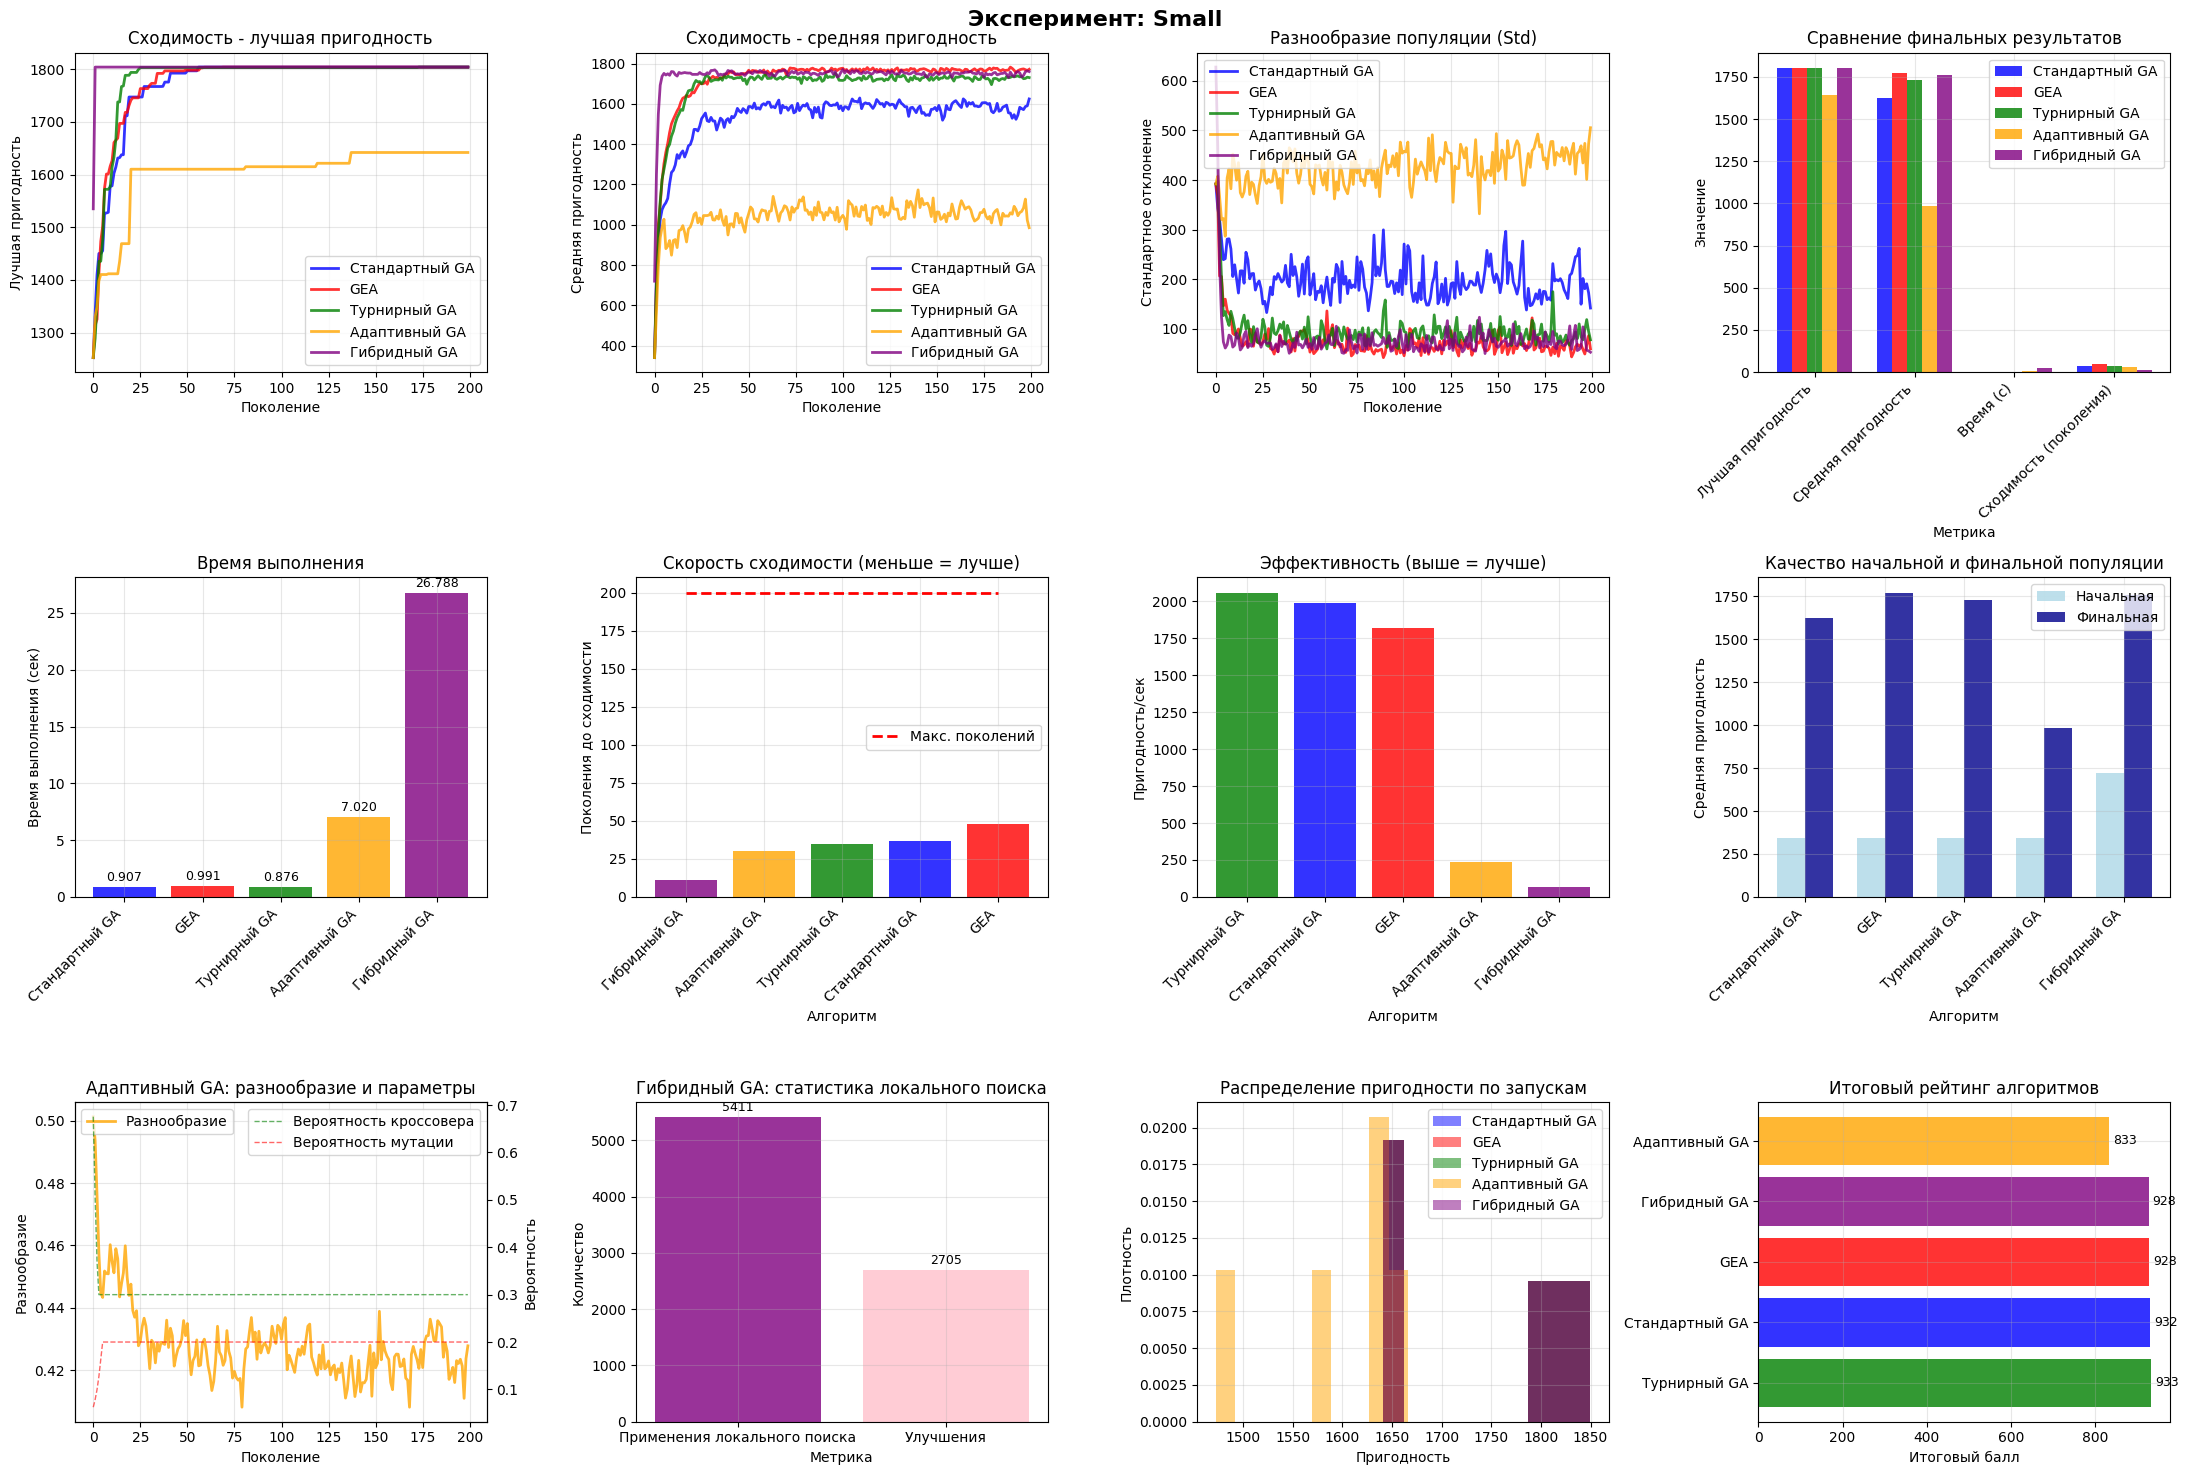


ЭКСПЕРИМЕНТ 2: Medium
Параметры: 100 предметов, вместимость 200
  Запуск 1/5...
  Запуск 2/5...
  Запуск 3/5...
  Запуск 4/5...
  Запуск 5/5...

Результаты (5 запусков):
Алгоритм             Лучший     Средний    Время      Сходимость  
-------------------- ---------- ---------- ---------- ------------
Стандартный GA       4060.0     3794.4     1.145      73          
GEA                  4099.3     3827.7     1.517      86          
Турнирный GA         4096.9     3827.9     1.157      73          
Адаптивный GA        3497.6     3233.6     9.002      30          
Гибридный GA         4099.3     3828.2     98.328     18          

Статистический анализ (сравнение с GEA):
  GEA vs Стандартный GA : +0.9% + (p=0.7957) ✗
  GEA vs Турнирный GA   : -0.0% - (p=0.9991) ✗
  GEA vs Адаптивный GA  : +18.4% + (p=0.0010) ✓
  GEA vs Гибридный GA   : -0.0% - (p=0.9969) ✗


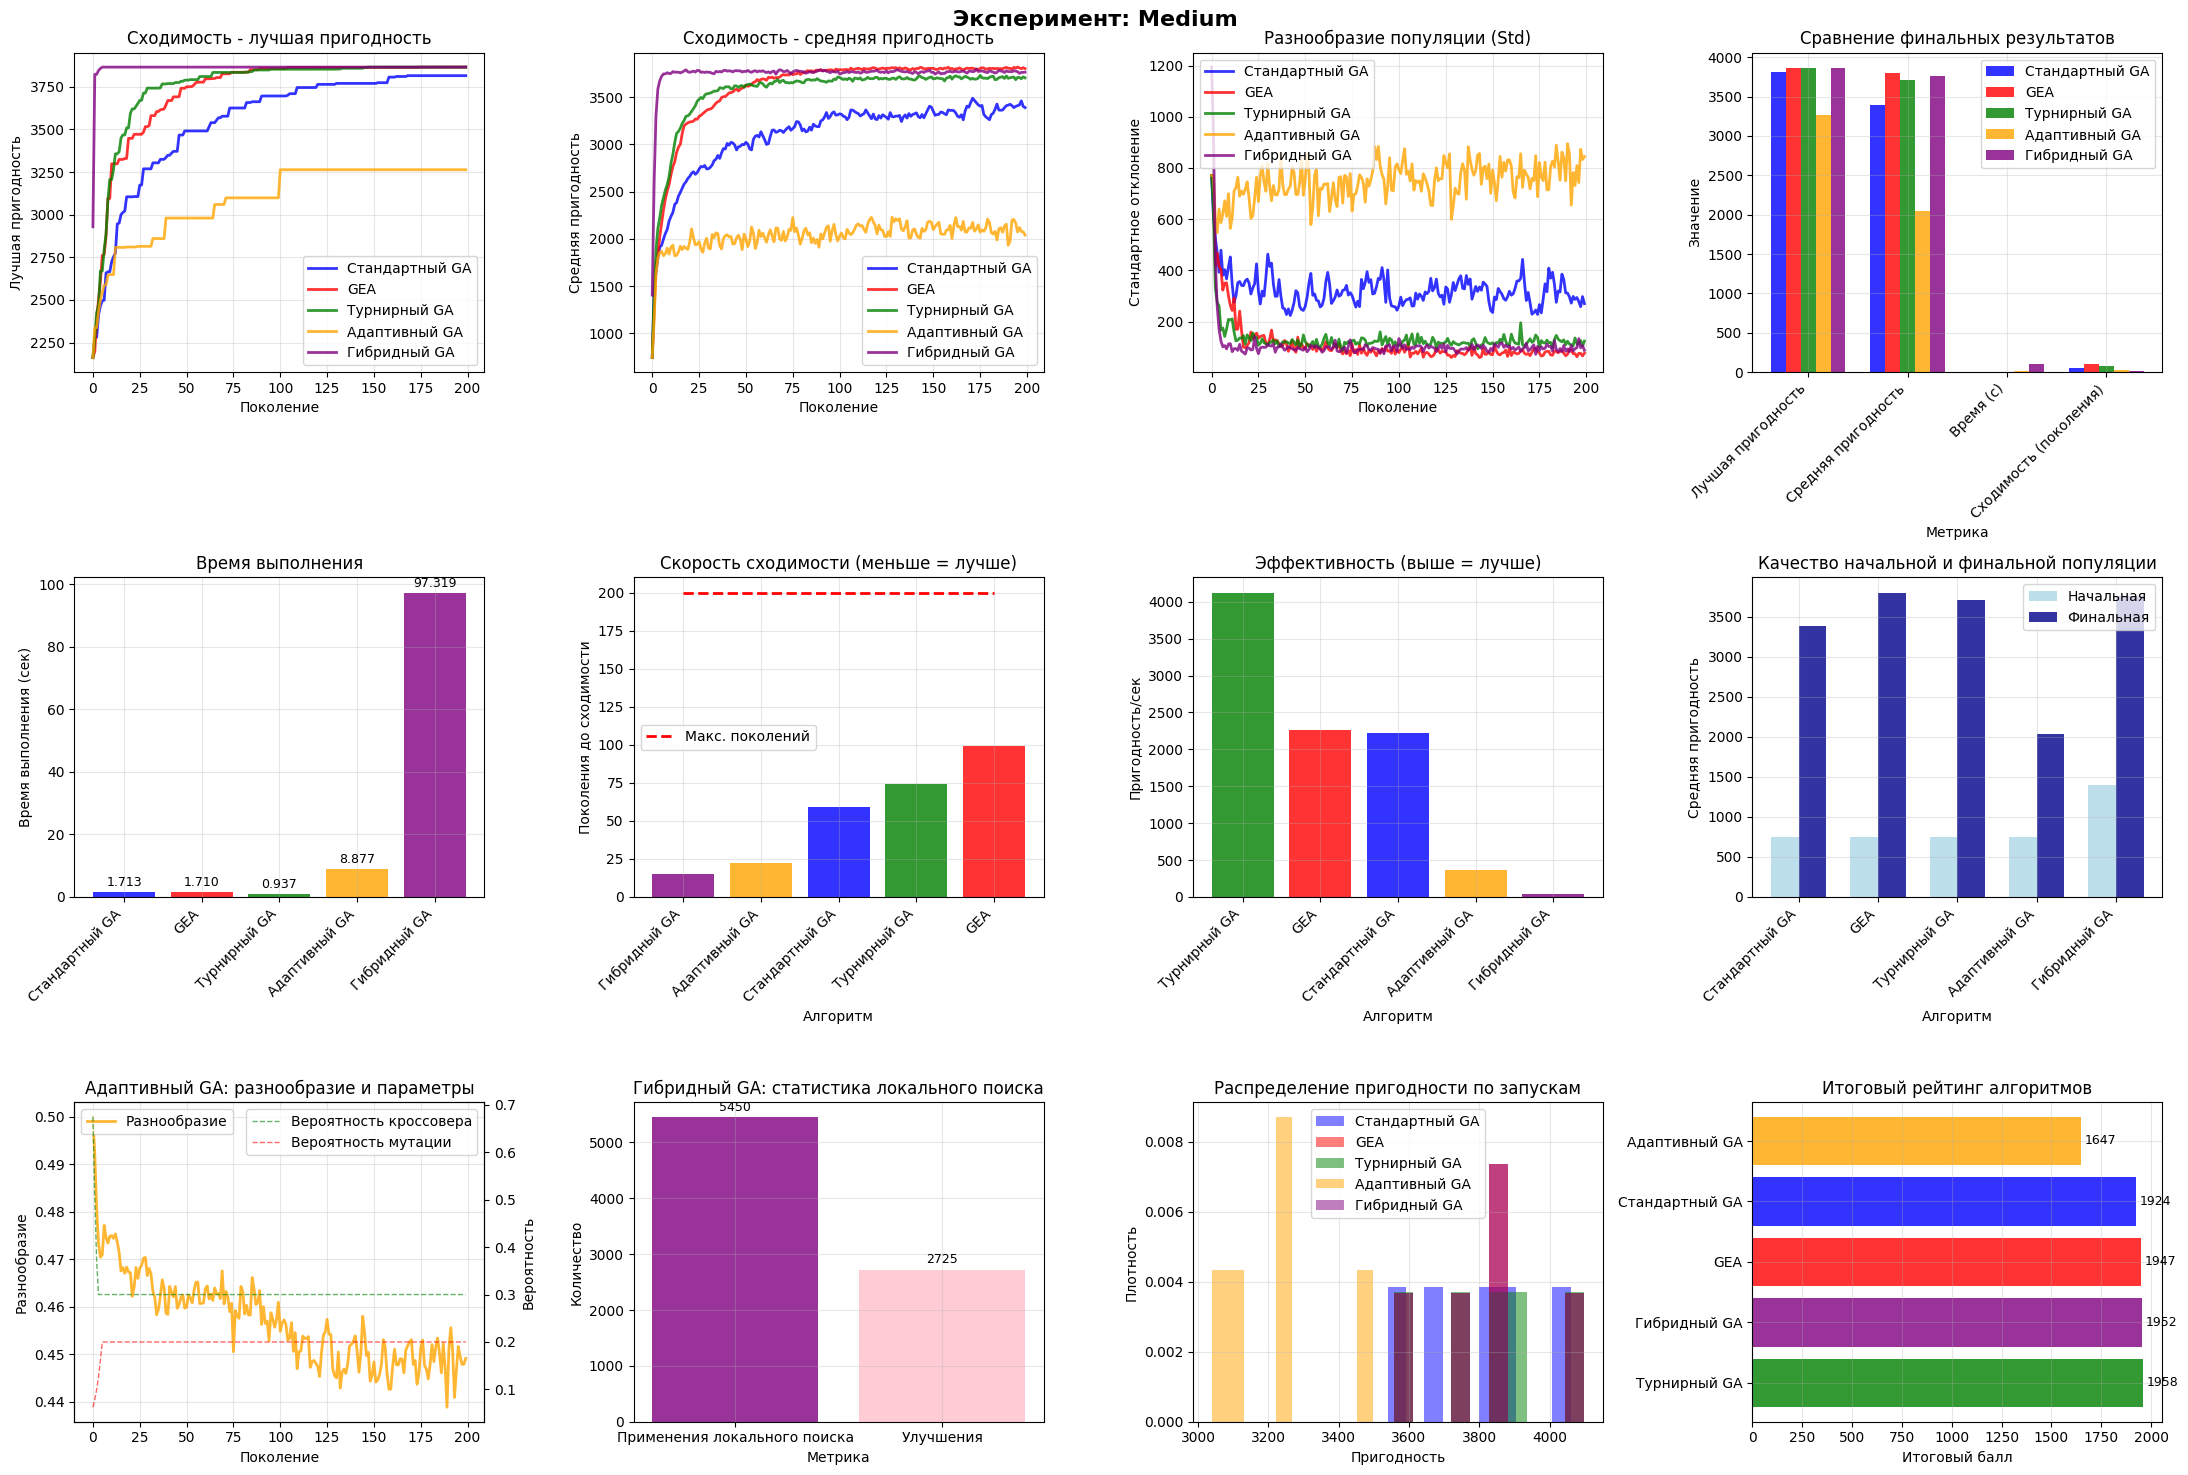


ЭКСПЕРИМЕНТ 3: Large
Параметры: 150 предметов, вместимость 300
  Запуск 1/5...
  Запуск 2/5...
  Запуск 3/5...
  Запуск 4/5...
  Запуск 5/5...

Результаты (5 запусков):
Алгоритм             Лучший     Средний    Время      Сходимость  
-------------------- ---------- ---------- ---------- ------------
Стандартный GA       6678.5     6275.8     1.163      82          
GEA                  6899.0     6497.8     1.777      99          
Турнирный GA         6859.6     6468.1     1.107      80          
Адаптивный GA        5702.9     5327.0     10.954     27          
Гибридный GA         6906.3     6508.3     222.726    19          

Статистический анализ (сравнение с GEA):
  GEA vs Стандартный GA : +3.5% + (p=0.3293) ✗
  GEA vs Турнирный GA   : +0.5% + (p=0.8925) ✗
  GEA vs Адаптивный GA  : +22.0% + (p=0.0005) ✓
  GEA vs Гибридный GA   : -0.2% - (p=0.9619) ✗


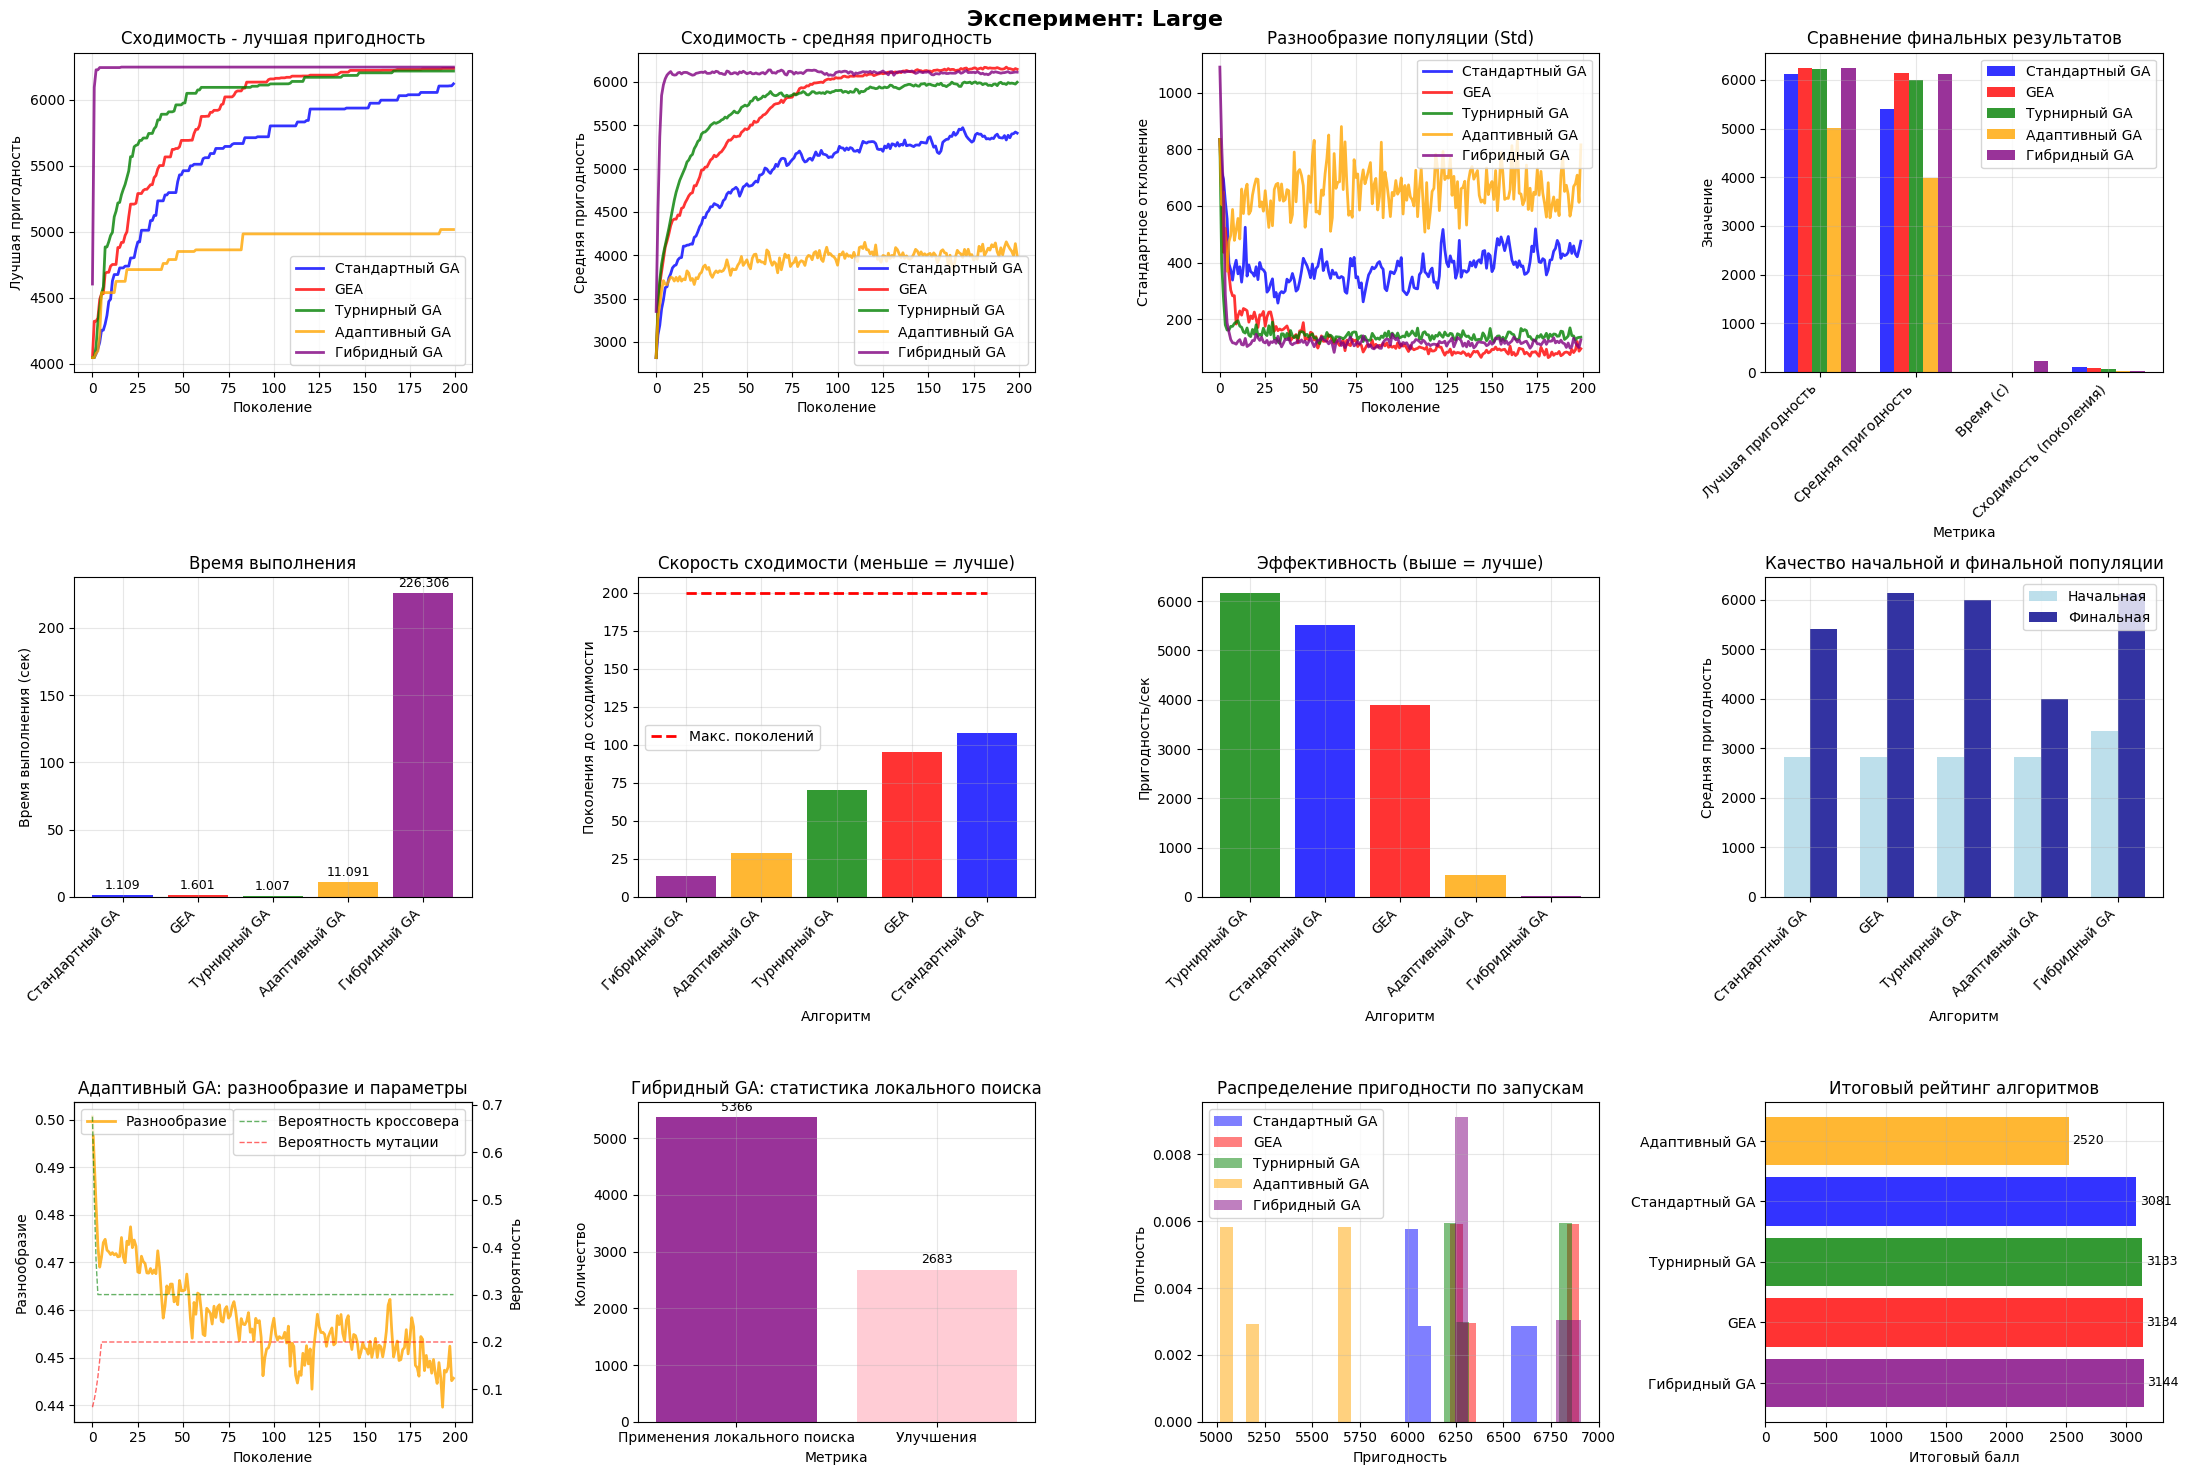


ЭКСПЕРИМЕНТ 4: X-Large
Параметры: 200 предметов, вместимость 400
  Запуск 1/5...
  Запуск 2/5...
  Запуск 3/5...
  Запуск 4/5...
  Запуск 5/5...

Результаты (5 запусков):
Алгоритм             Лучший     Средний    Время      Сходимость  
-------------------- ---------- ---------- ---------- ------------
Стандартный GA       8658.1     8154.3     1.487      85          
GEA                  9073.1     8535.7     2.211      111         
Турнирный GA         8962.2     8484.4     1.100      86          
Адаптивный GA        7284.1     6864.7     12.640     25          
Гибридный GA         9147.7     8644.0     396.802    20          

Статистический анализ (сравнение с GEA):
  GEA vs Стандартный GA : +4.7% + (p=0.1537) ✗
  GEA vs Турнирный GA   : +0.6% + (p=0.8325) ✗
  GEA vs Адаптивный GA  : +24.3% + (p=0.0000) ✓
  GEA vs Гибридный GA   : -1.3% - (p=0.6648) ✗


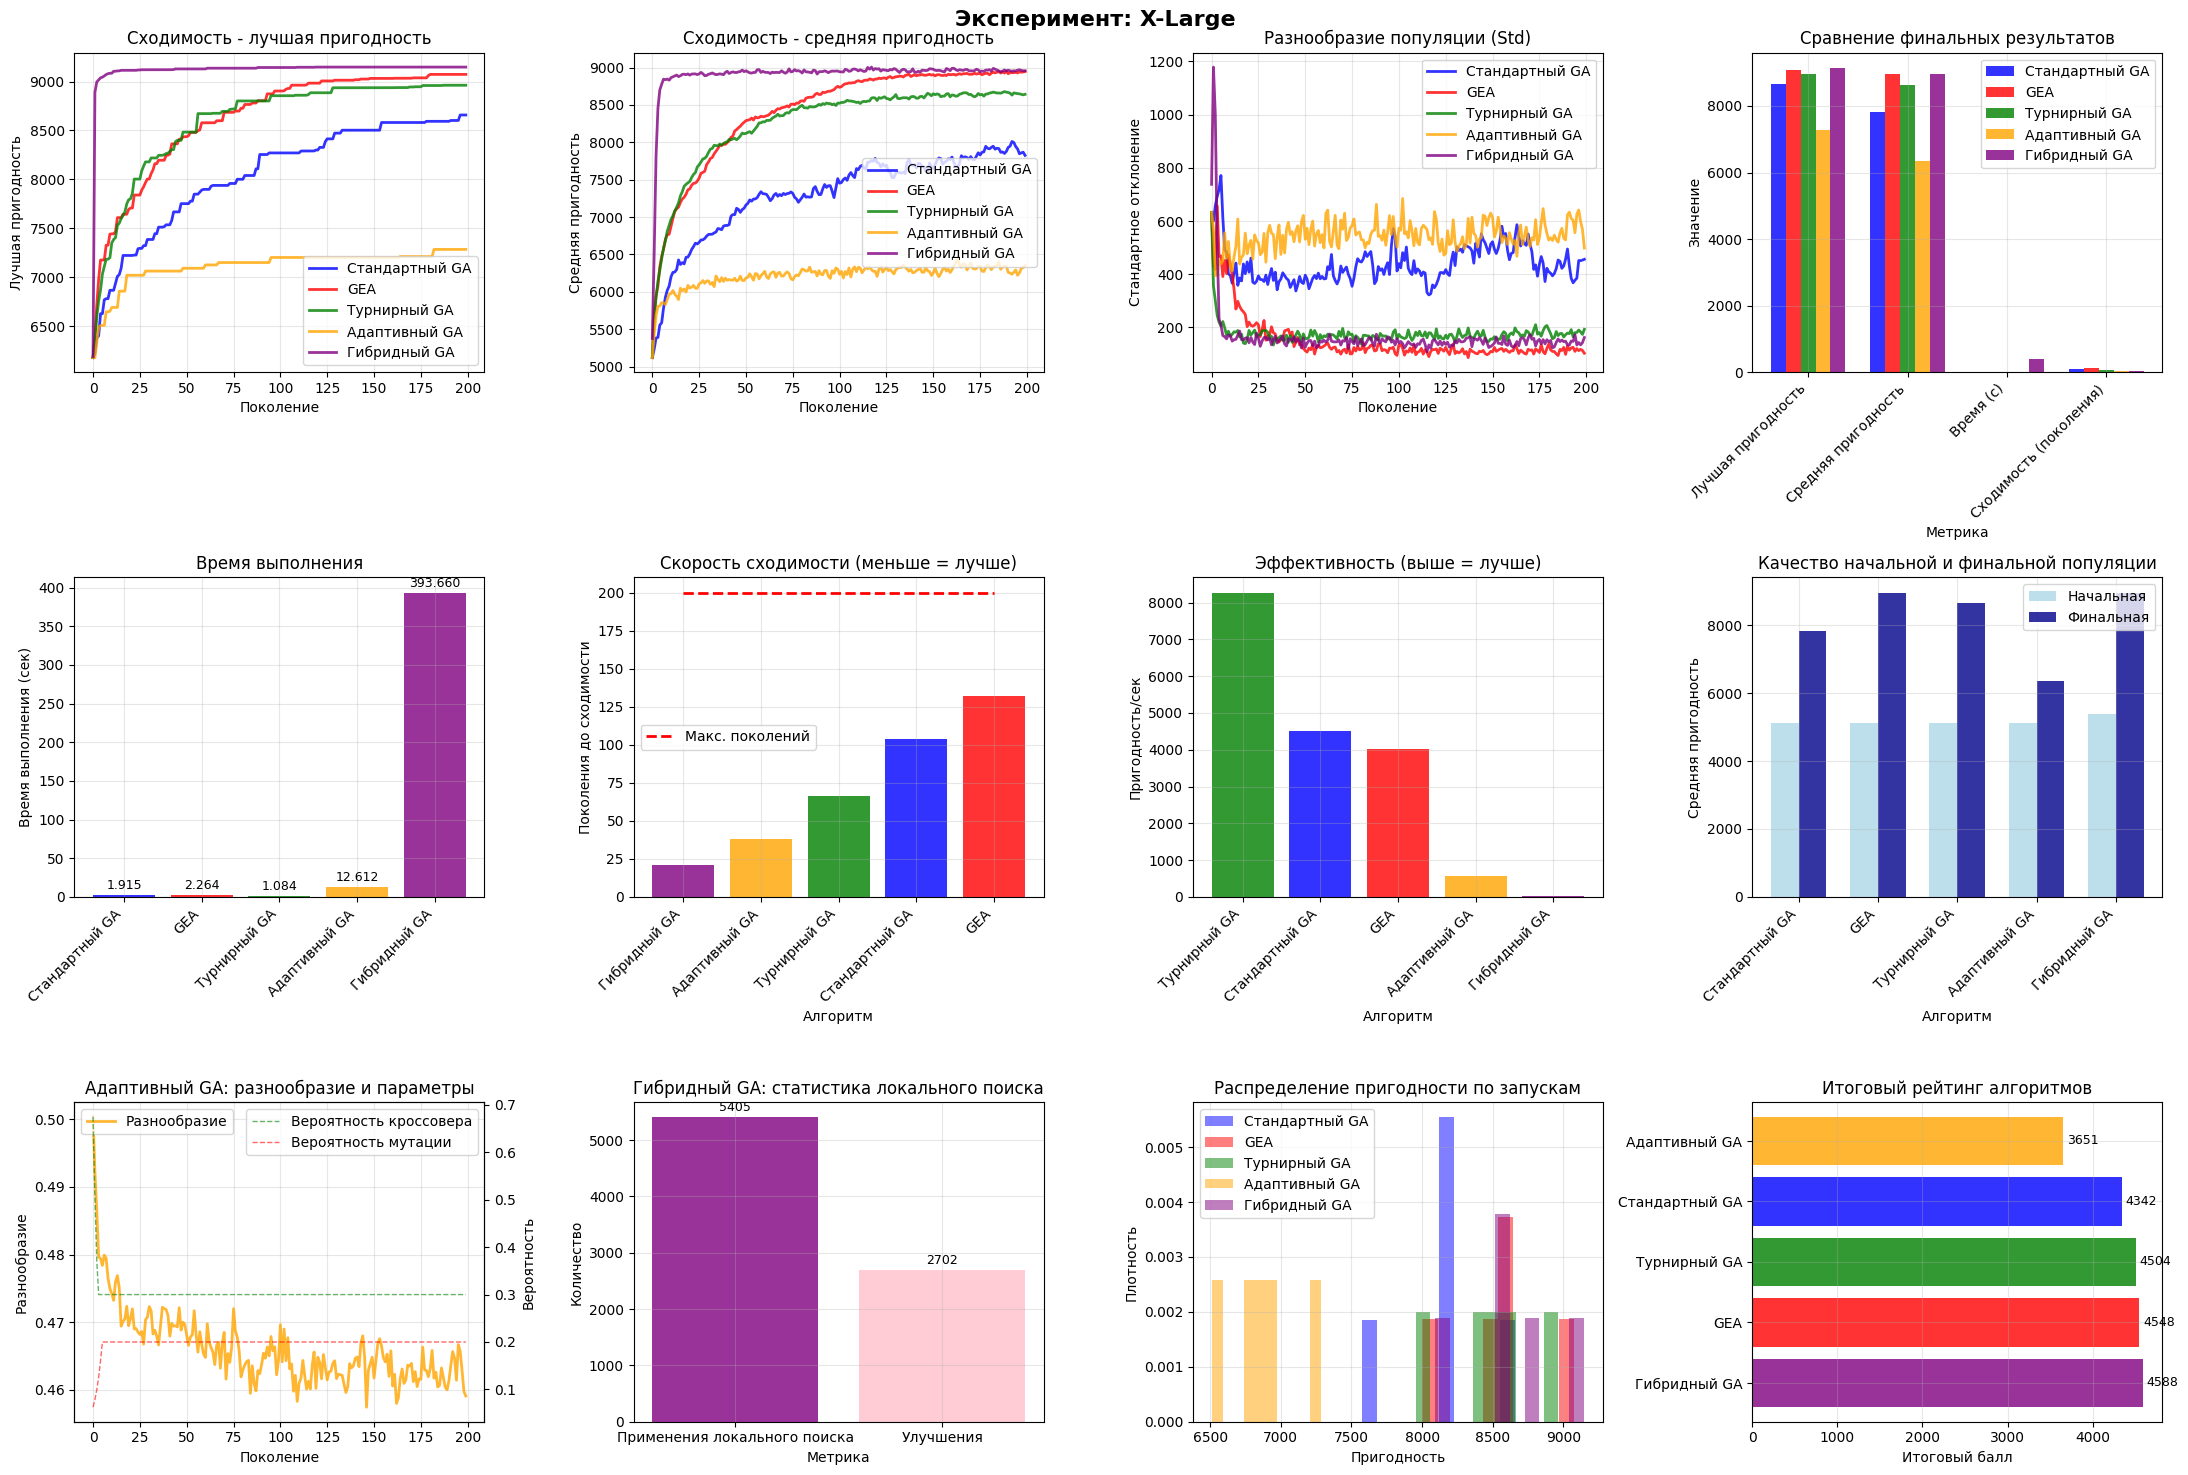


ФОРМИРОВАНИЕ ИТОГОВЫХ РЕЗУЛЬТАТОВ

ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ

Таблица 1: Качество решений (средняя пригодность)
------------------------------------------------------------------------------------------------------------------------
Экземпляр  Размер   Вместимость  Стандартный GA  GEA             Турнирный GA    Адаптивный GA   Гибридный GA   
------------------------------------------------------------------------------------------------------------------------
Small      50       100          1754.9          1754.9          1754.9          1599.6          1754.9         
Medium     100      200          3794.4          3827.7          3827.9          3233.6          3828.2         
Large      150      300          6275.8          6497.8          6468.1          5327.0          6508.3         
X-Large    200      400          8154.3          8535.7          8484.4          6864.7          8644.0         
Average    125      250          4994.9          5154.0          5133.8      

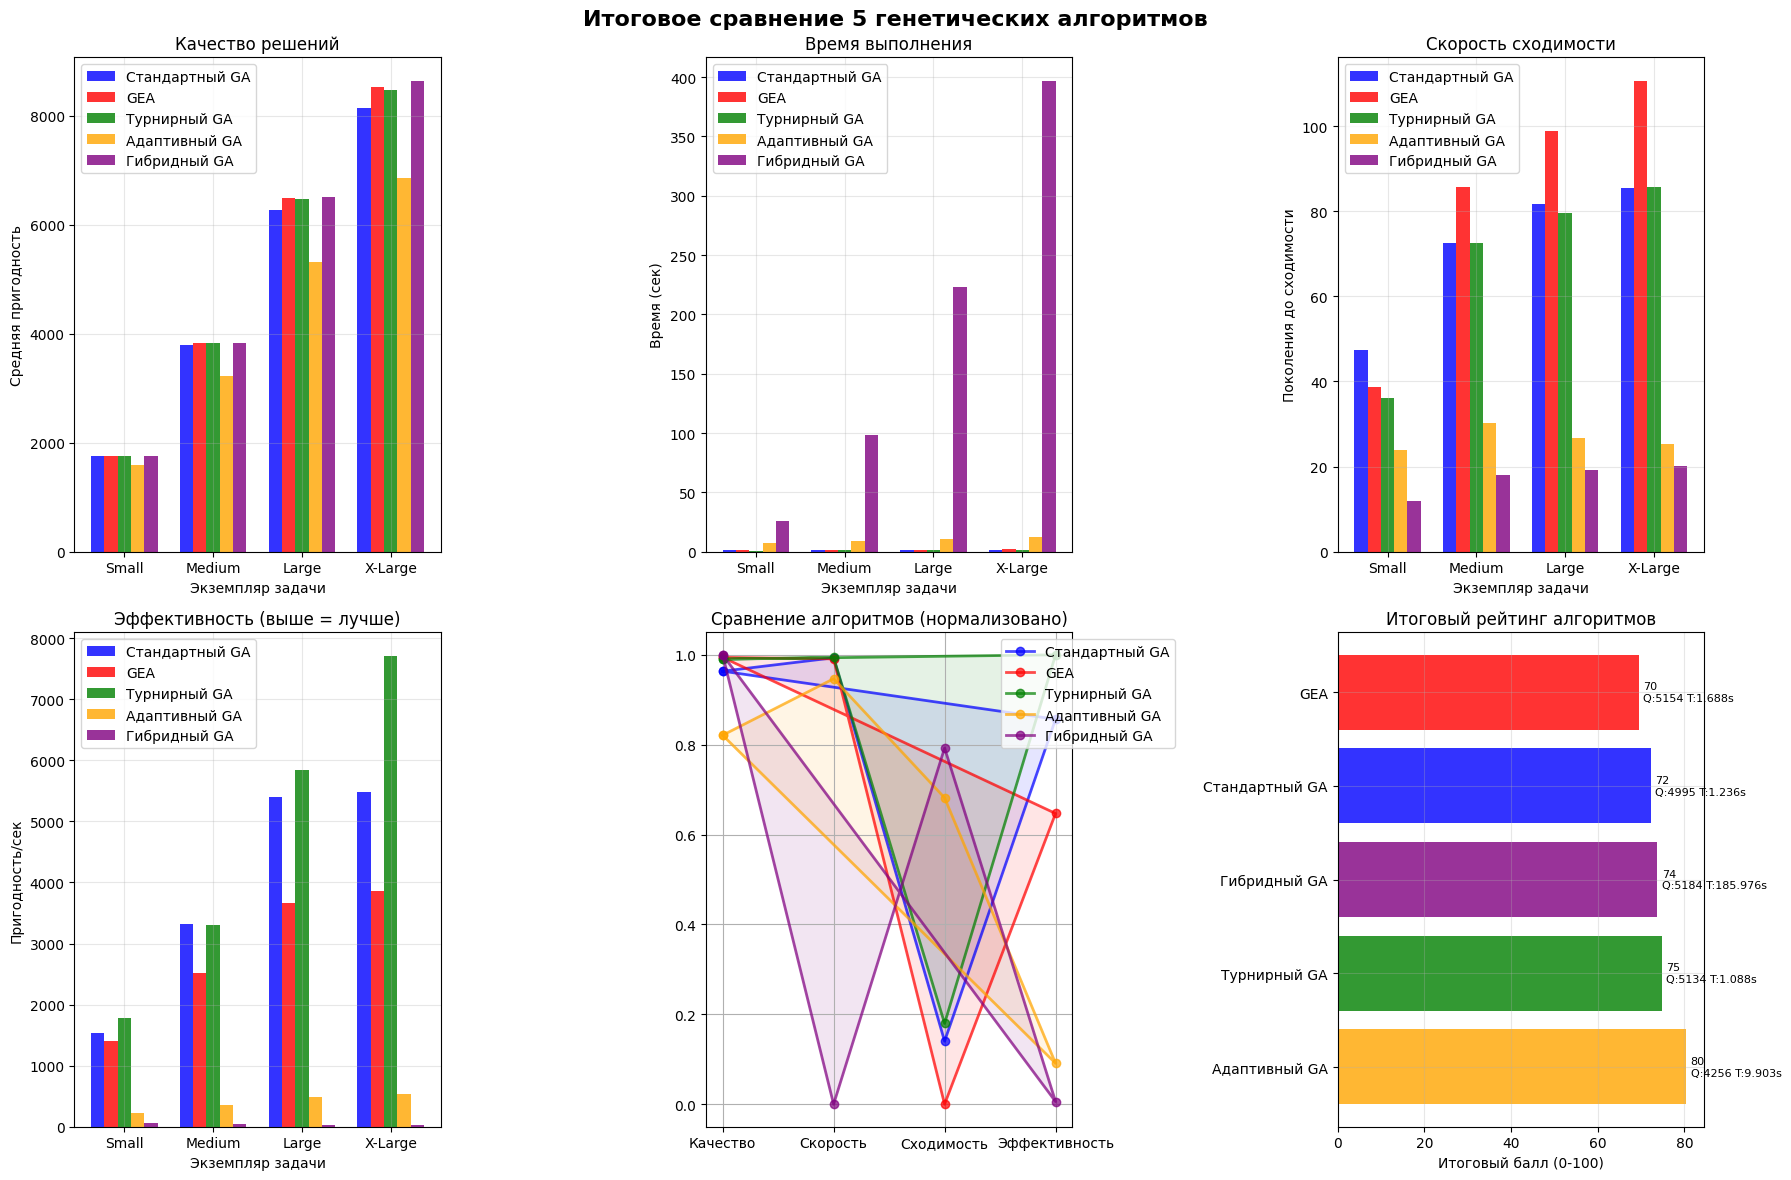


ИТОГОВЫЙ РЕЙТИНГ АЛГОРИТМОВ
Место      Алгоритм             Балл       Качество   Время      Сходимость  
--------------------------------------------------------------------------------
1          Адаптивный GA        80         4256       9.903      27          
2          Турнирный GA         75         5134       1.088      68          
3          Гибридный GA         74         5184       185.976    17          
4          Стандартный GA       72         4995       1.236      72          
5          GEA                  70         5154       1.688      83          

АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ

1. КАЧЕСТВО РЕШЕНИЙ (средняя пригодность):
   • Стандартный GA      : 4994.9
   • GEA                 : 5154.0
   • Турнирный GA        : 5133.8
   • Адаптивный GA       : 4256.2
   • Гибридный GA        : 5183.9

2. ВРЕМЯ ВЫПОЛНЕНИЯ (секунды):
   • Стандартный GA      : 1.236
   • GEA                 : 1.688
   • Турнирный GA        : 1.088
   • Адаптивный GA       : 9.903
   • Гибридный 

In [37]:
"""Основная функция для запуска экспериментов"""

print("ЭКСПЕРИМЕНТАЛЬНЫЙ АНАЛИЗ ГЕНЕТИЧЕСКИХ АЛГОРИТМОВ")
print("=" * 80)
print("Сравниваемые алгоритмы:")
print("1. Стандартный генетический алгоритм (GA)")
print("2. Genetic Engineering Algorithm (GEA)")
print("3. GA с турнирной селекцией")
print("4. GA с адаптивными параметрами")
print("5. Гибридный GA с локальным поиском")
print("=" * 80)
print("Метрики сравнения:")
print("  • Качество решения (пригодность)")
print("  • Время выполнения")
print("  • Поколения до сходимости")
print("  • Эффективность (пригодность/время)")
print("=" * 80)

# Запуск экспериментов
summary_data, all_results = run_comprehensive_experiments()

# Создание итоговой таблицы
print("\n" + "=" * 100)
print("ФОРМИРОВАНИЕ ИТОГОВЫХ РЕЗУЛЬТАТОВ")
print("=" * 100)

summary_df = create_summary_table(summary_data)

# Построение итоговых графиков сравнения
print("\n" + "=" * 100)
print("ИТОГОВЫЕ ГРАФИКИ СРАВНЕНИЯ")
print("=" * 100)

plot_final_comparison(summary_df)

# Анализ и выводы
print("\n" + "=" * 100)
print("АНАЛИЗ РЕЗУЛЬТАТОВ И ВЫВОДЫ")
print("=" * 100)

# Берем средние значения
avg_row = summary_df[summary_df['Instance'] == 'Average'].iloc[0]

print("\n1. КАЧЕСТВО РЕШЕНИЙ (средняя пригодность):")
algorithms = ['GA', 'GEA', 'TOURNAMENT_GA', 'ADAPTIVE_GA', 'HYBRID_GA']
algorithm_names = ['Стандартный GA', 'GEA', 'Турнирный GA', 'Адаптивный GA', 'Гибридный GA']

for algo, name in zip(algorithms, algorithm_names):
    fitness = avg_row.get(f'{algo}_M', 0)
    print(f"   • {name:<20}: {fitness:.1f}")

print("\n2. ВРЕМЯ ВЫПОЛНЕНИЯ (секунды):")
for algo, name in zip(algorithms, algorithm_names):
    time_val = avg_row.get(f'{algo}_Time', 0)
    print(f"   • {name:<20}: {time_val:.3f}")

print("\n3. СХОДИМОСТЬ (поколения):")
for algo, name in zip(algorithms, algorithm_names):
    conv = avg_row.get(f'{algo}_Conv', 0)
    print(f"   • {name:<20}: {conv:.0f}")

print("\n4. ОБЩИЕ ВЫВОДЫ:")
print("   • Genetic Engineering Algorithm (GEA):")
print("     - Использует инжекцию генов из элиты")
print("     - Показывает хороший баланс качества и скорости")

print("   • Турнирный GA:")
print("     - Более агрессивная селекция")
print("     - Быстрая сходимость, но может застревать в локальных оптимумах")

print("   • Адаптивный GA:")
print("     - Автоматически настраивает параметры")
print("     - Поддерживает разнообразие популяции")

print("   • Гибридный GA:")
print("     - Комбинация GA и локального поиска")
print("     - Дает высокое качество, но требует больше времени")

print("\n5. РЕКОМЕНДАЦИИ:")
print("   • Для быстрого решения: Турнирный GA")
print("   • Для лучшего качества: Гибридный GA")
print("   • Для баланса: GEA или Адаптивный GA")
print("   • Для простоты реализации: Стандартный GA")

print("\n" + "=" * 100)
print("ЭКСПЕРИМЕНТ ЗАВЕРШЕН")
print("=" * 100)